In [1]:
# Import libraries

import os
import time
import warnings
import numpy as np
from datetime import date
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

# Disble ignore warnings
warnings.filterwarnings('ignore')

## Core functions

In [2]:
## Ellipse Classifier Class
class EllipseC:    
    def __init__(self, c_x, c_y, r_x, r_y):
        self.c_x = c_x
        self.c_y = c_y
        self.r_x = r_x
        self.r_y = r_y
    
    def set_CX(self, nc_x):
        self.c_x = nc_x
        
    def set_CY(self, nc_y):
        self.c_y = nc_y
        
    def set_RX(self, nr_x):
        self.r_x = nr_x
        
    def set_RY(self, nr_y):
        self.r_y = nr_y
    
    ## Check if a measurement is inside the boundaries of the ellipse
    def isInEllipse(self, x, y):
        if pow((x - self.c_x), 2)/pow(self.r_x, 2) + pow((y - self.c_y), 2)/pow(self.r_y, 2) <= 1:
            return 1
        else:
            return 0

## Return the number of measurements inside an Ellipse
def numInEllipse(E, X, Y):
    num = 0
    for p in zip(X, Y):
        if E.isInEllipse(p[0], p[1]):
            num += 1
    return num

## Return the number of measurement inside two Ellipses (the intersection between the state 0 and state 1 ellipse)
def numBetweenEllipses(E_state0, E_state1, X, Y):
    num = 0
    for p in zip(X, Y):
        if E_state0.isInEllipse(p[0], p[1]) and E_state1.isInEllipse(p[0], p[1]):
            num += 1
    return num

## NOT USED
## Tie breaker inside the intersection zone. This is based on distance to the center of each ellipse
def classifyBetweenEllipses(E_state0, E_state1, X, Y):
    num_0 = 0
    num_1 = 0
    for p in zip(X, Y):
        if E_state0.isInEllipse(p[0], p[1]) and E_state1.isInEllipse(p[0], p[1]):
            dist_E0 = np.linalg.norm([E_state0.c_x - p[0], E_state0.c_y - p[1]], 2)
            dist_E1 = np.linalg.norm([E_state1.c_x - p[0], E_state1.c_y - p[1]], 2)
            if (dist_E0 >= dist_E1):
                num_1 += 1
            else:
                num_0 += 1
    return num_0, num_1

## The error is defined as |predicted_prob - original_prob|. The predicted probability depends on the classifier used.
## This function only works for E2C_ignore and E2C_decay. E2C_inter_distance is no longer used.
def getError(train_data, train_prob_0, decay_prob, E_state0, E_state1, mode):
    err = []
    for i in range(len(train_data)):
        x = np.real(train_data[i])
        y = np.imag(train_data[i])

        num_state_0 = numInEllipse(E_state0, x, y)
        num_state_1 = numInEllipse(E_state1, x, y)
        
        num_inter = numBetweenEllipses(E_state0, E_state1, x, y)
        
        num_state_0 -= num_inter
        num_state_1 -= num_inter
        
        if mode == "ignore":
            if num_state_0 + num_state_1 != 0:
                prob_0 = num_state_0 / (num_state_0 + num_state_1)
                err.append(abs(train_prob_0[i] - prob_0))
            
                print_err = train_prob_0[i] - prob_0
                
#                 visualizeEllipse_train(E_state0, E_state1, train_d_1[i])
                
        elif mode == "inter_distance":
            num0_inter, num1_inter = classifyBetweenEllipses(E_state0, E_state1, x, y)
            num_state_0 += num0_inter
            num_state_1 += num1_inter

            prob_0 = num_state_0 / (num_state_0 + num_state_1)
            err.append(abs(train_prob_0[i] - prob_0))
            
        elif mode == "decay":
            num_state_0 -= int(num_state_1*decay_prob)
            num_state_1 += int(num_state_1*decay_prob)
            
            prob_0 = num_state_0 / (num_state_0 + num_state_1)
            err.append(abs(train_prob_0[i] - prob_0))
            
    return err

# Sample the performance of a configuration. This is taken from DISQ code
def E2D_sample_perf(config, obj, train_d_1, train_o_p):

    o_pf_up = [1]*len(train_d_1)
    o_pf_dn = [1]*len(train_d_1)
    
    A0 = (np.cos(config[2])/config[3])**2 + (np.sin(config[2])/config[4])**2
    B0 = 2 * np.cos(config[2]) * np.sin(config[2]) * ((1/config[3]**2) - (1/config[4]**2))
    C0 = (np.sin(config[2])/config[3])**2 + (np.cos(config[2])/config[4])**2
    
    A1 = (np.cos(config[7])/config[8])**2 + (np.sin(config[7])/config[9])**2
    B1 = 2 * np.cos(config[7]) * np.sin(config[7]) * ((1/config[8]**2) - (1/config[9]**2))
    C1 = (np.sin(config[7])/config[8])**2 + (np.cos(config[7])/config[9])**2
        
    for i in range(len(train_d_1)):
        x0 = np.real(train_d_1[i]) - config[0]
        y0 = np.imag(train_d_1[i]) - config[1]
        frac_0 = sum(A0*x0**2 + B0*x0*y0 + C0*y0**2 <= 1)
        x1 = np.real(train_d_1[i]) - config[5]
        y1 = np.imag(train_d_1[i]) - config[6]
        frac_1 = sum(A1*x1**2 + B1*x1*y1 + C1*y1**2 <= 1)
        if frac_0 + frac_1 != 0:
            frac_0 /= (frac_0 + frac_1)
            o_pf_up[i] = abs(train_o_p[i]-frac_0)
            o_pf_dn[i] = abs(train_o_p[i]-(1-frac_0))
        
    perf_up = None
    perf_dn = None
    if obj == 'median':
        perf_up = np.median(o_pf_up)
        perf_dn = np.median(o_pf_dn)
    elif obj == 'spread':
        perf_up = np.percentile(o_pf_up, 75) - np.percentile(o_pf_up, 25)
        perf_dn = np.percentile(o_pf_dn, 75) - np.percentile(o_pf_dn, 25)
    elif obj == 'mdnspd':
        perf_up = np.median(o_pf_up) + (np.percentile(o_pf_up, 75) - np.percentile(o_pf_up, 25))
        perf_dn = np.median(o_pf_dn) + (np.percentile(o_pf_dn, 75) - np.percentile(o_pf_dn, 25))
        
    if perf_up < perf_dn:
        print("I'm here")
        return o_pf_up
    else:
        return o_pf_dn

## Date information and objectives

In [3]:
date_dir = ['2021-10-29', '2021-10-30', '2021-10-31', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06', '2021-11-07', '2021-11-08']
objectives = ["median", "spread", "mdnspd"]

## Error vs Original Output Probability Plots (For IBM, E2D_DISQ, E2C_ignore, and E2C_delay)
### Per Day

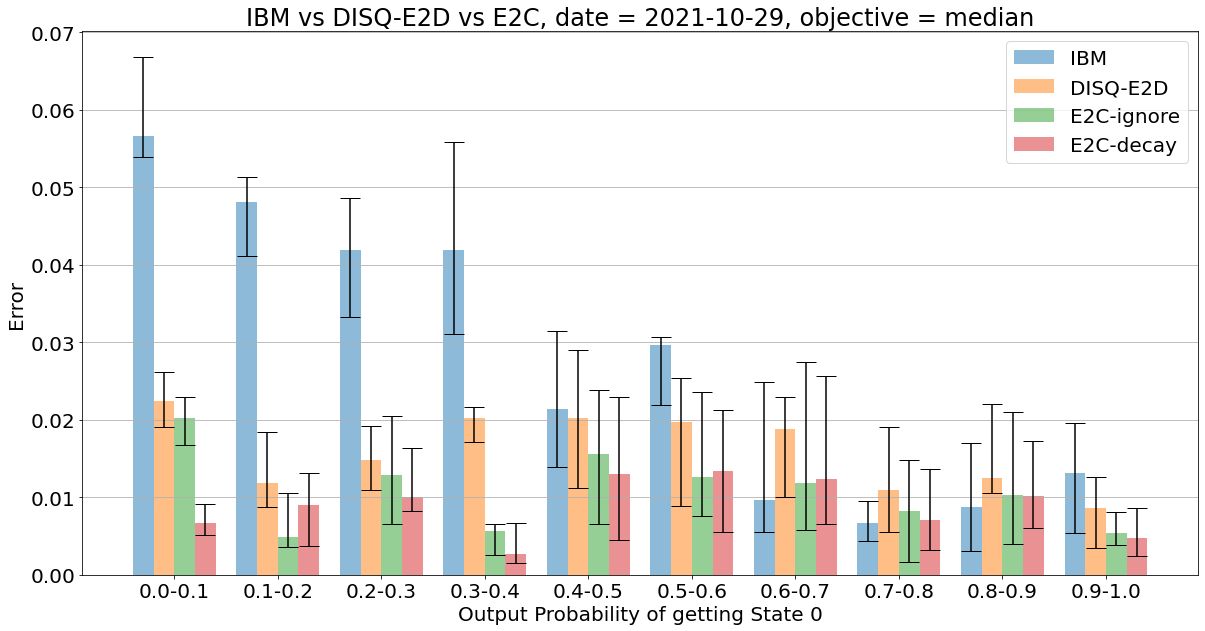

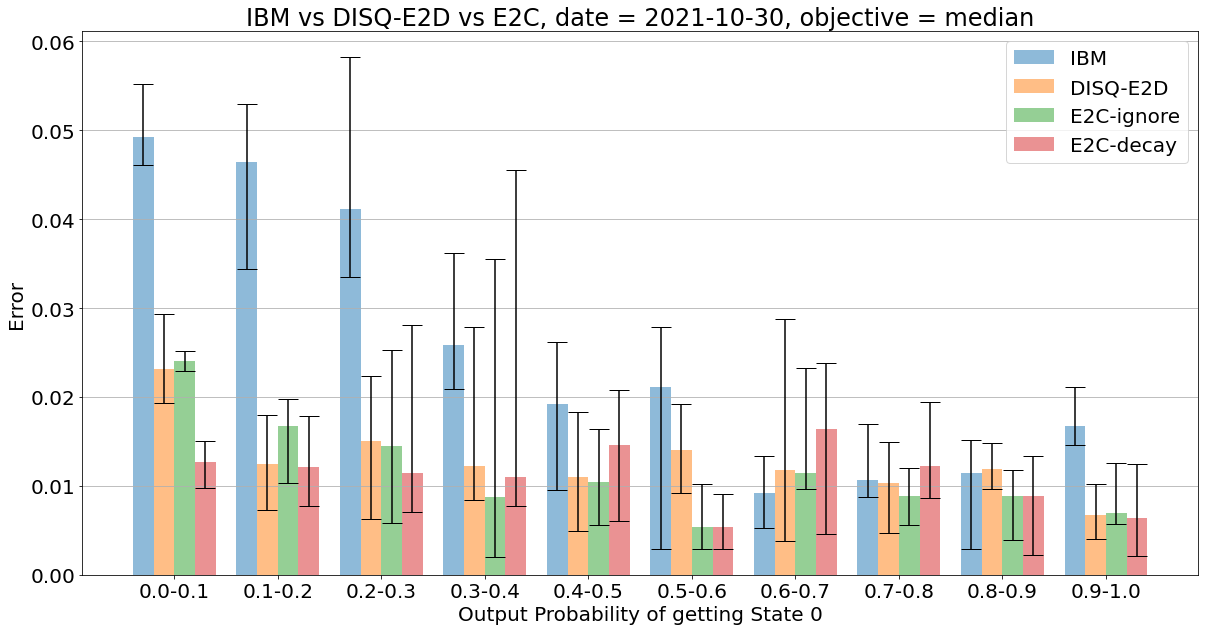

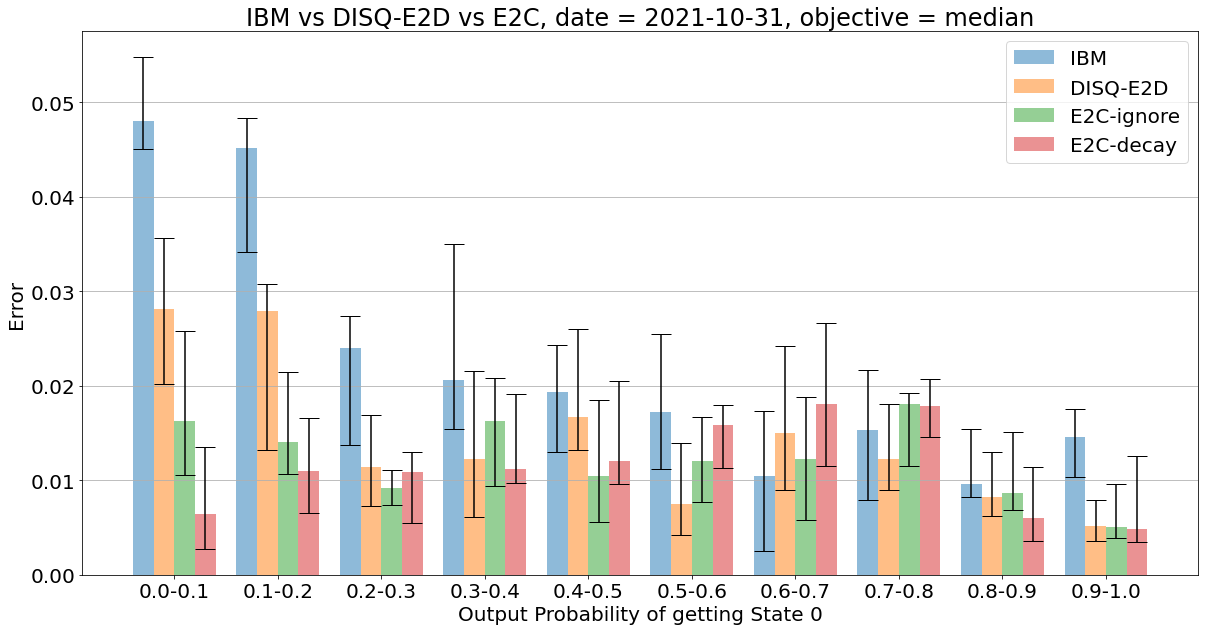

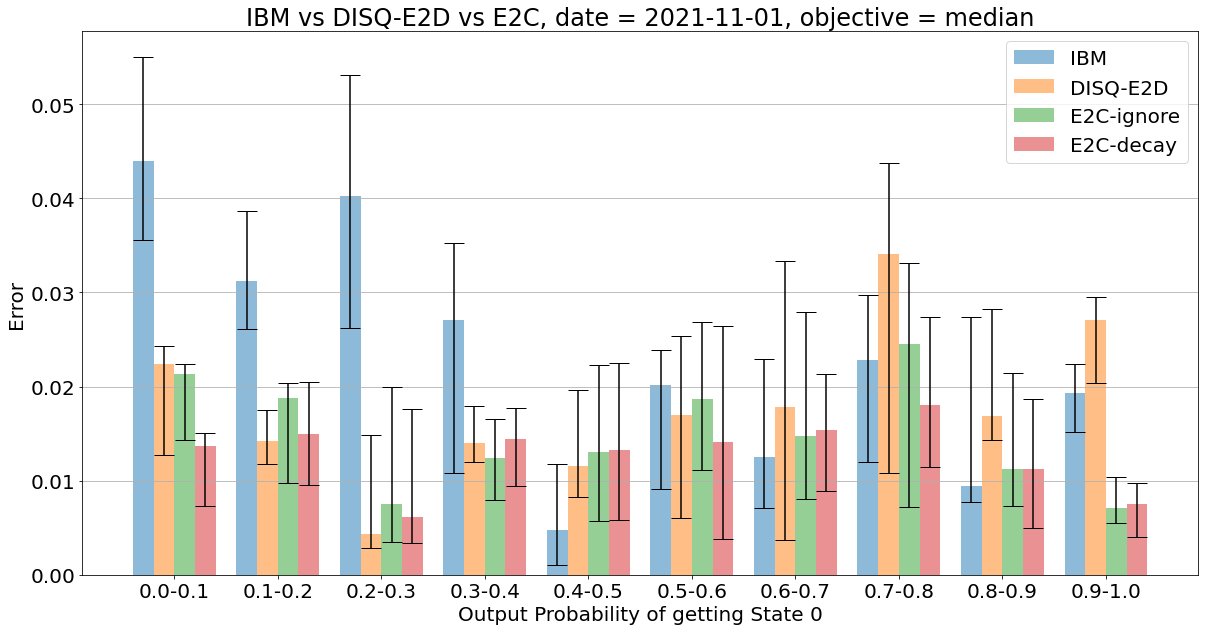

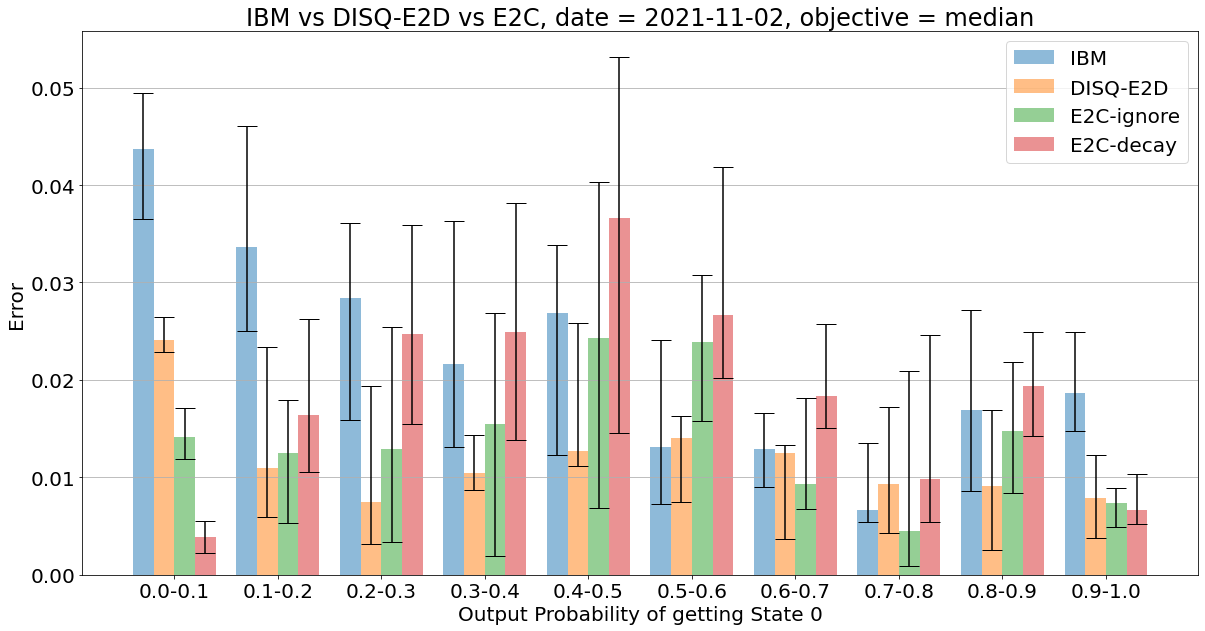

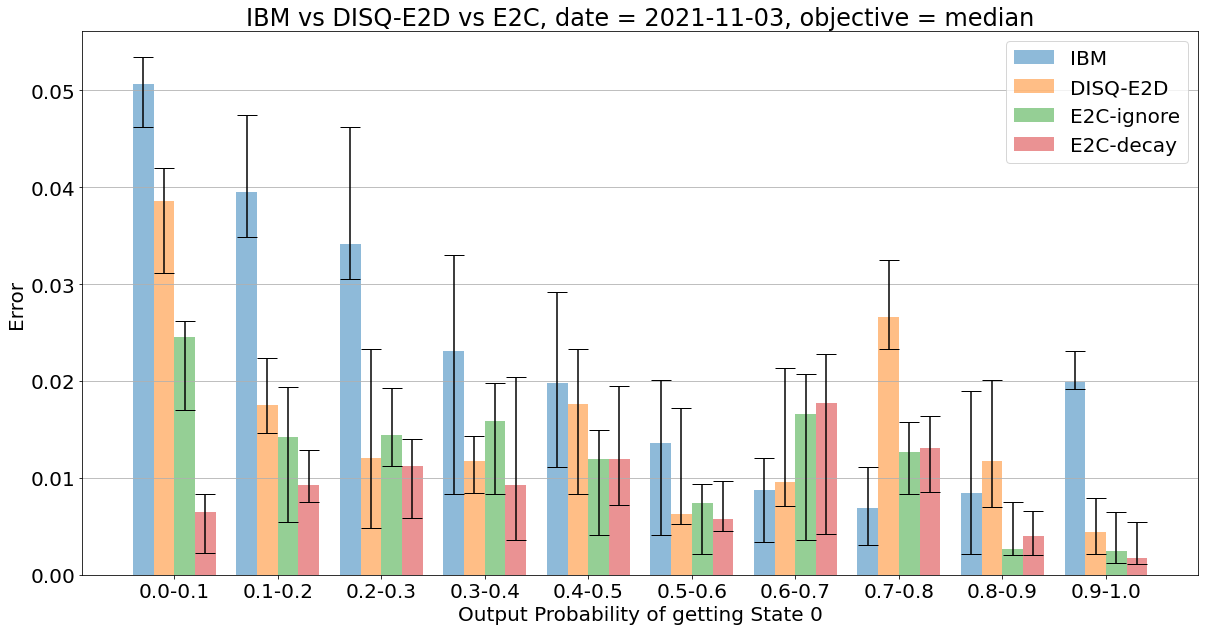

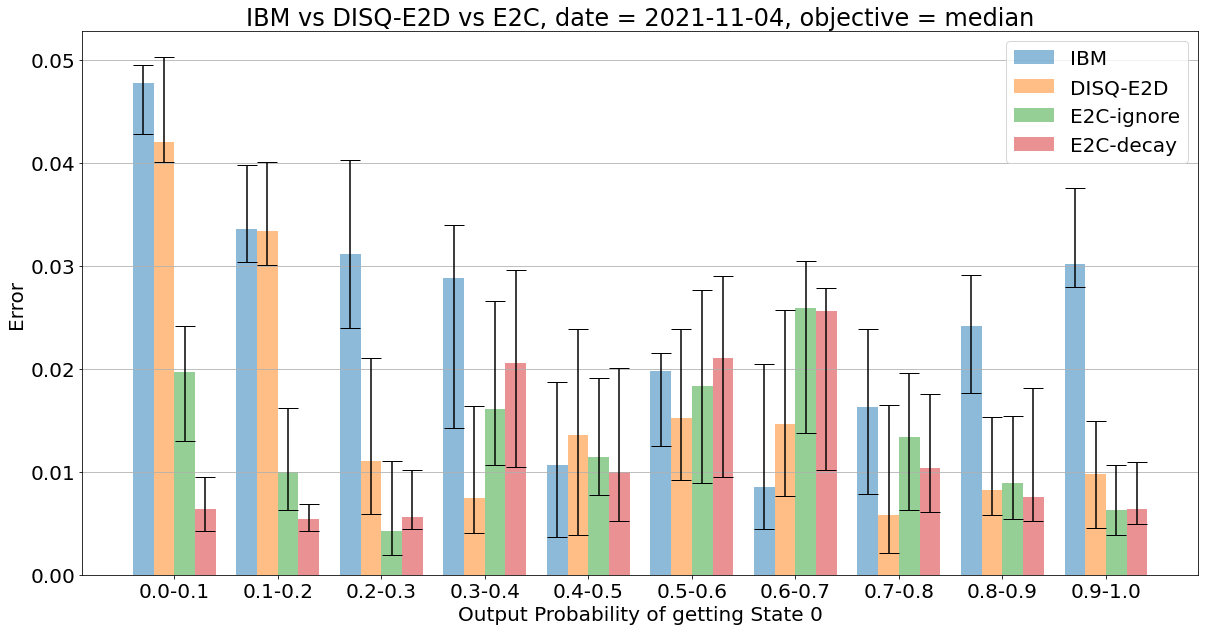

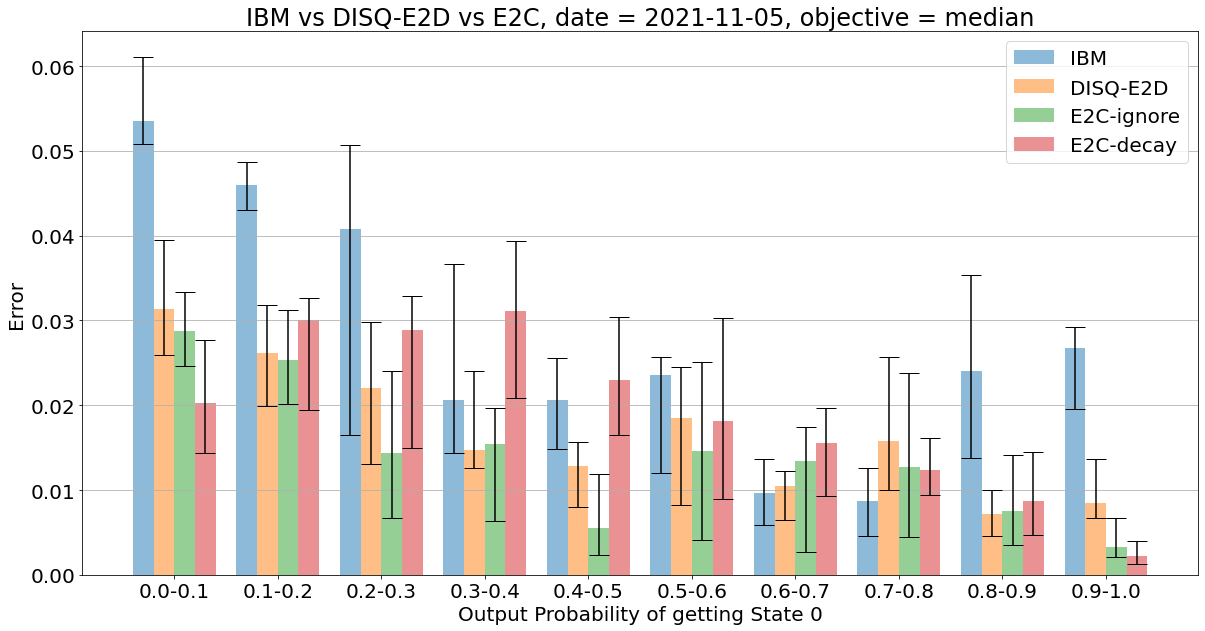

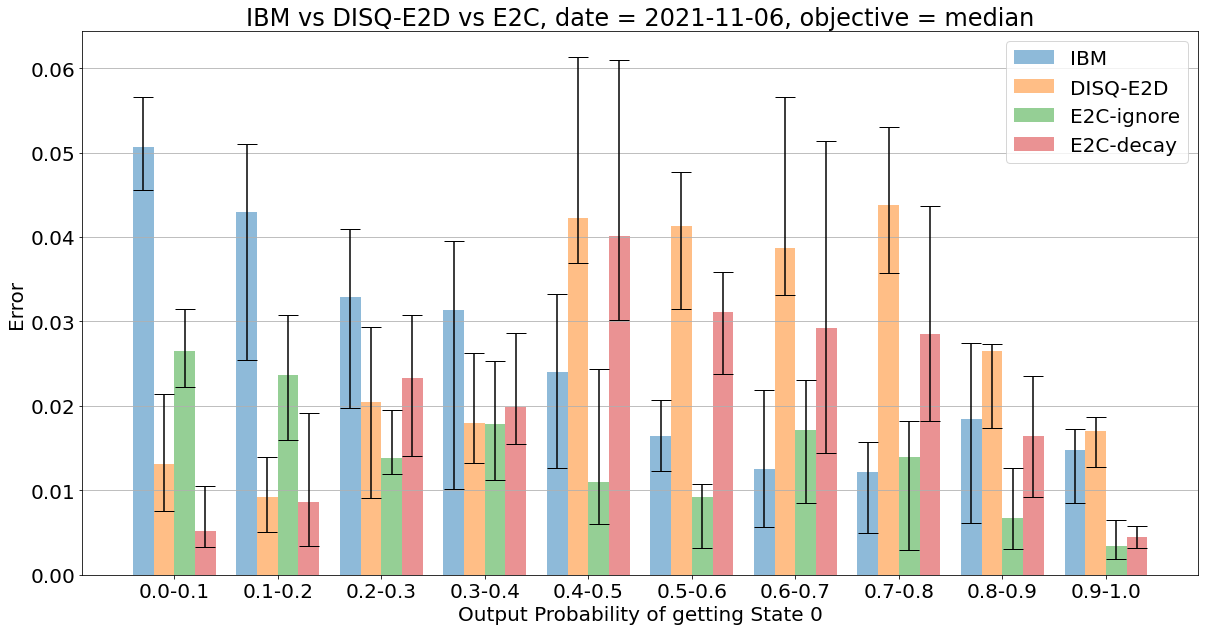

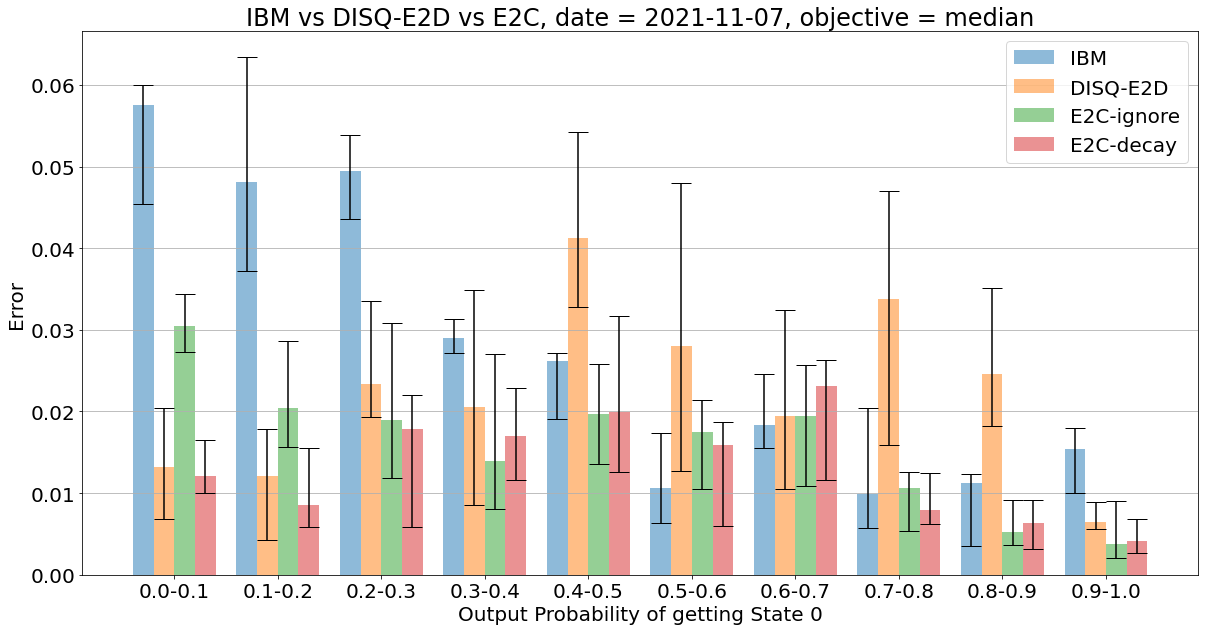

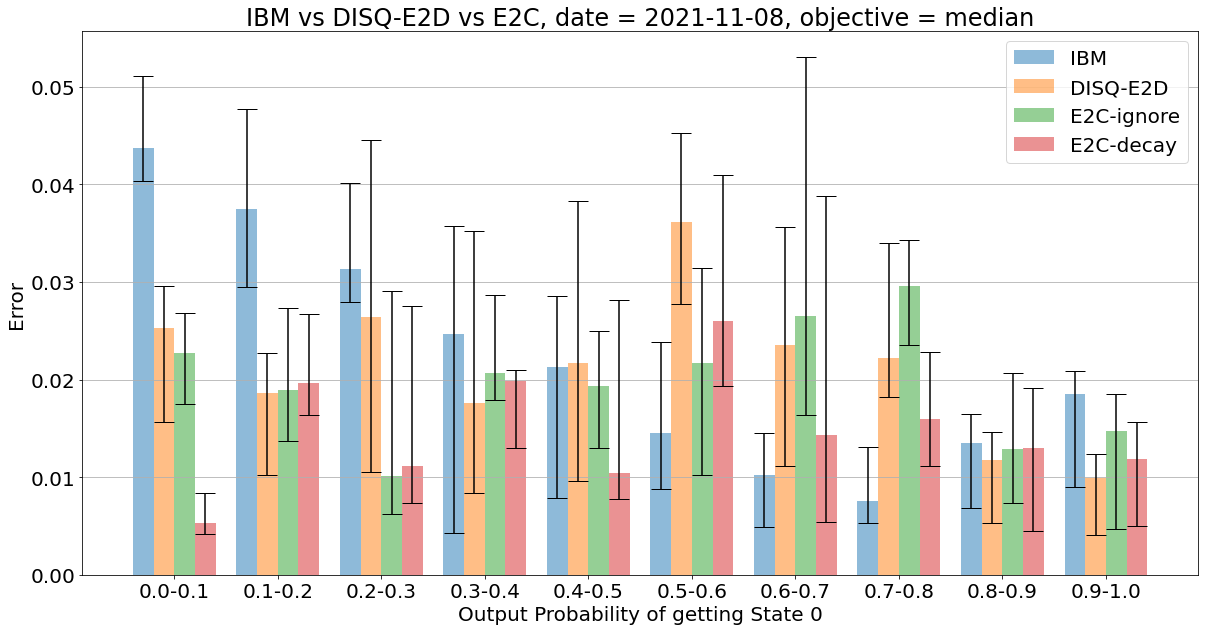

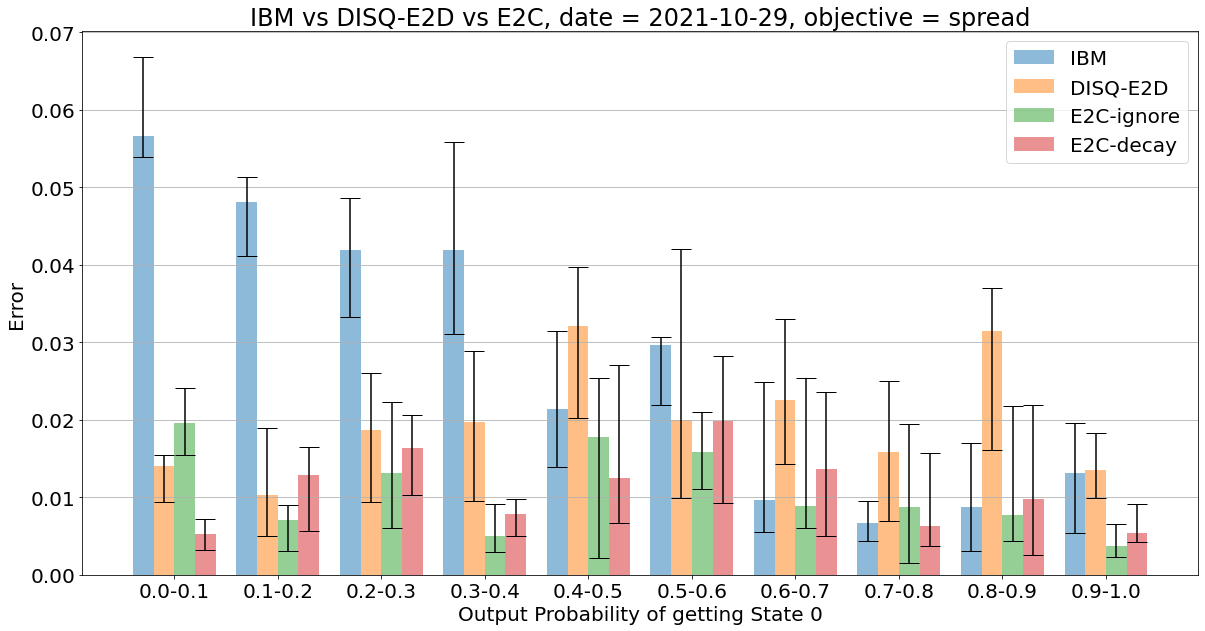

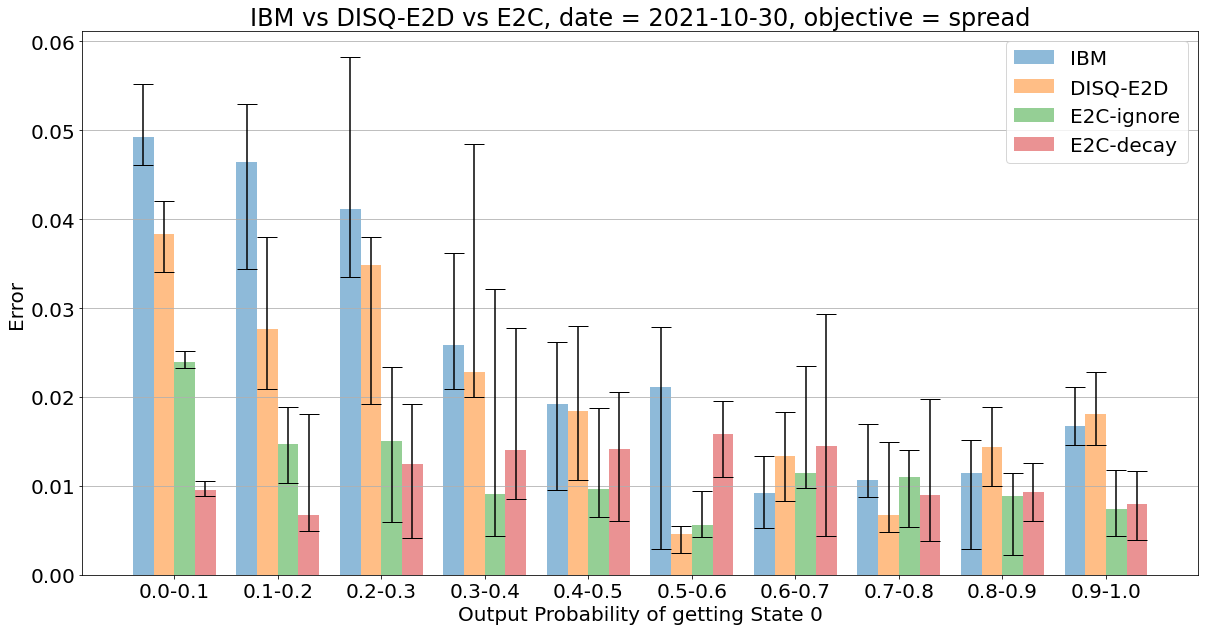

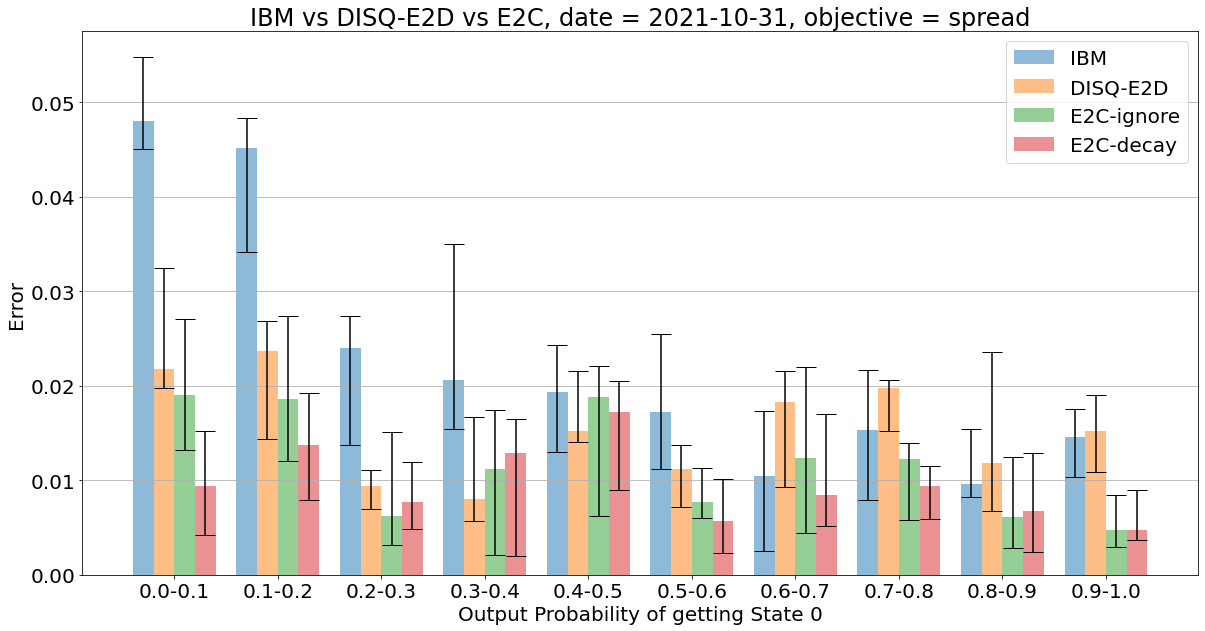

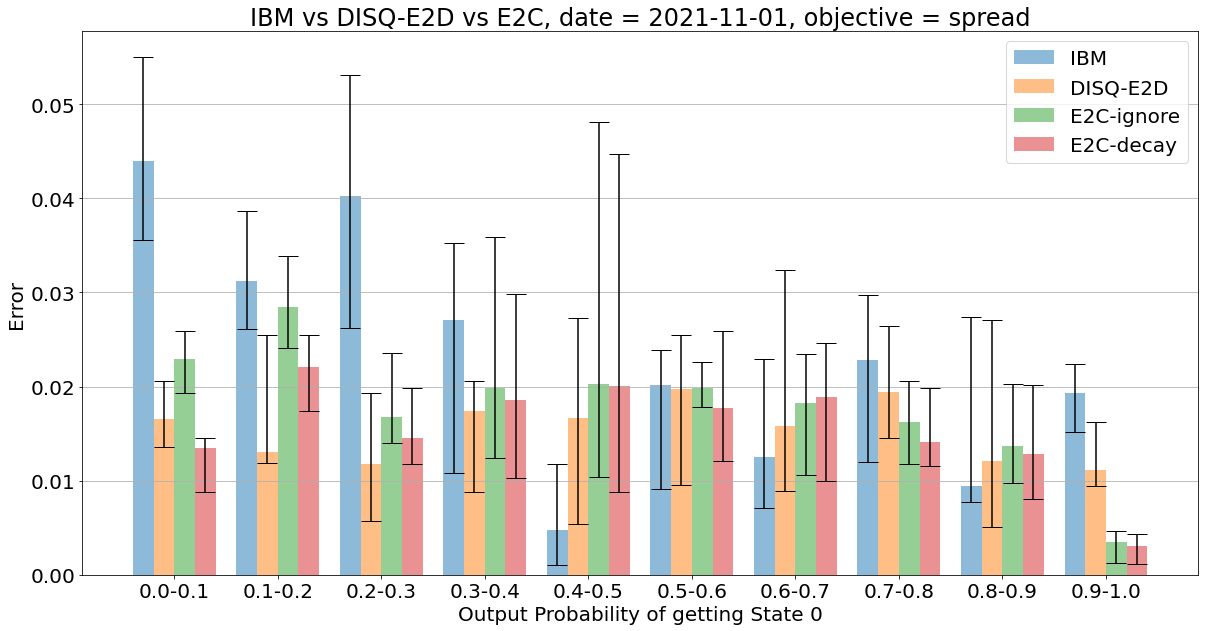

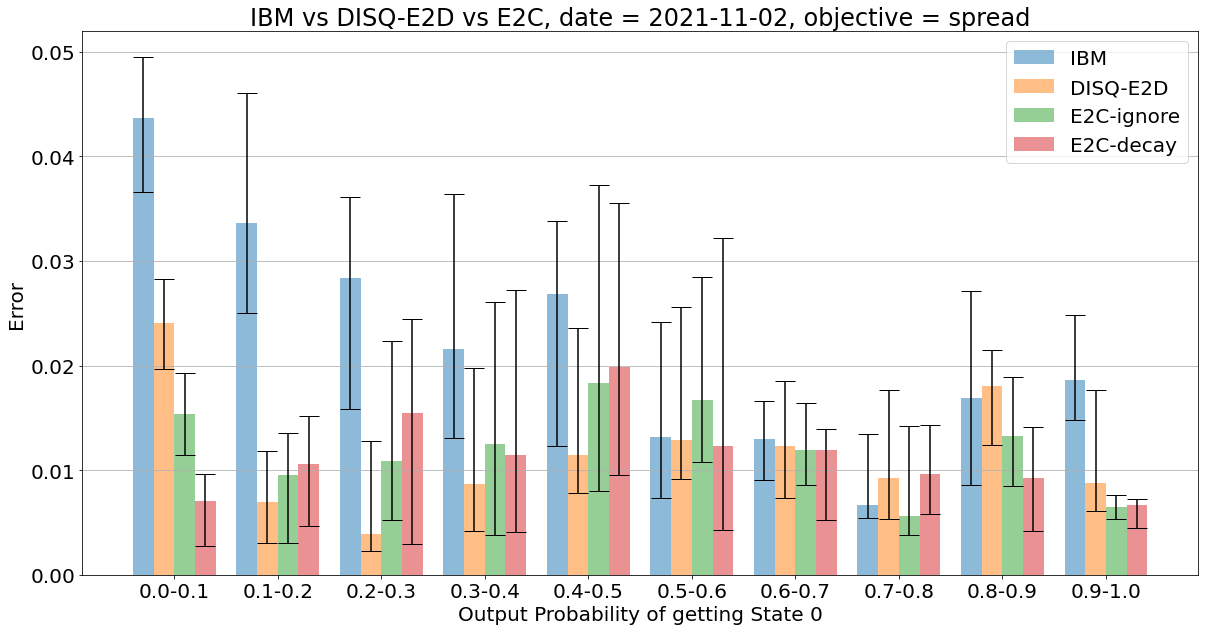

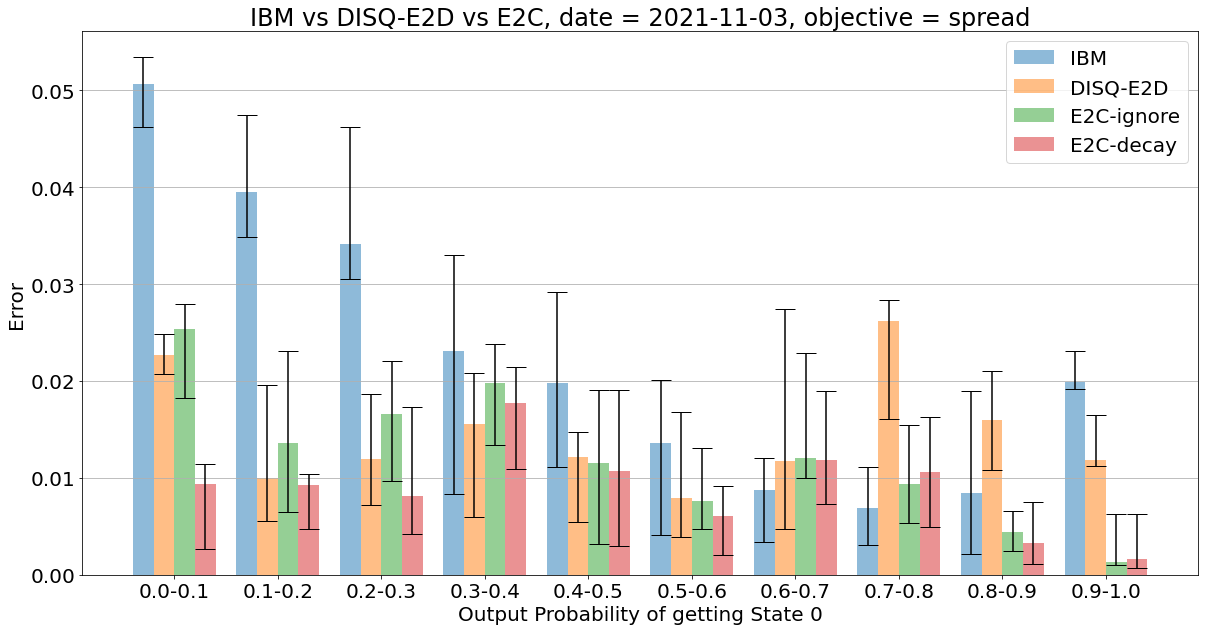

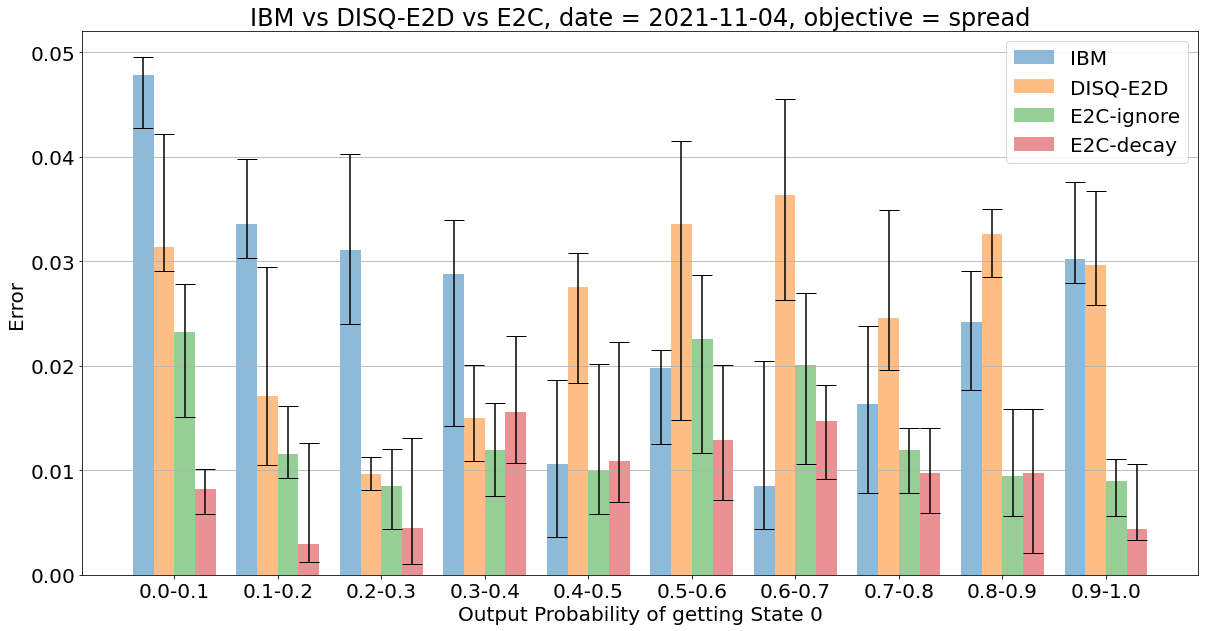

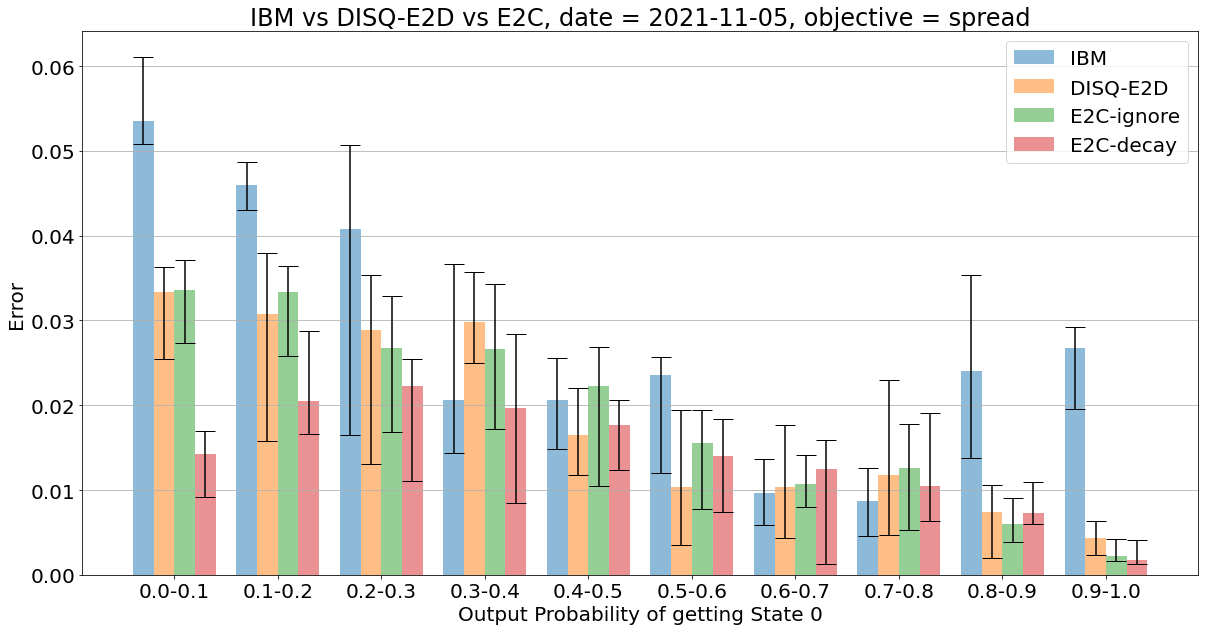

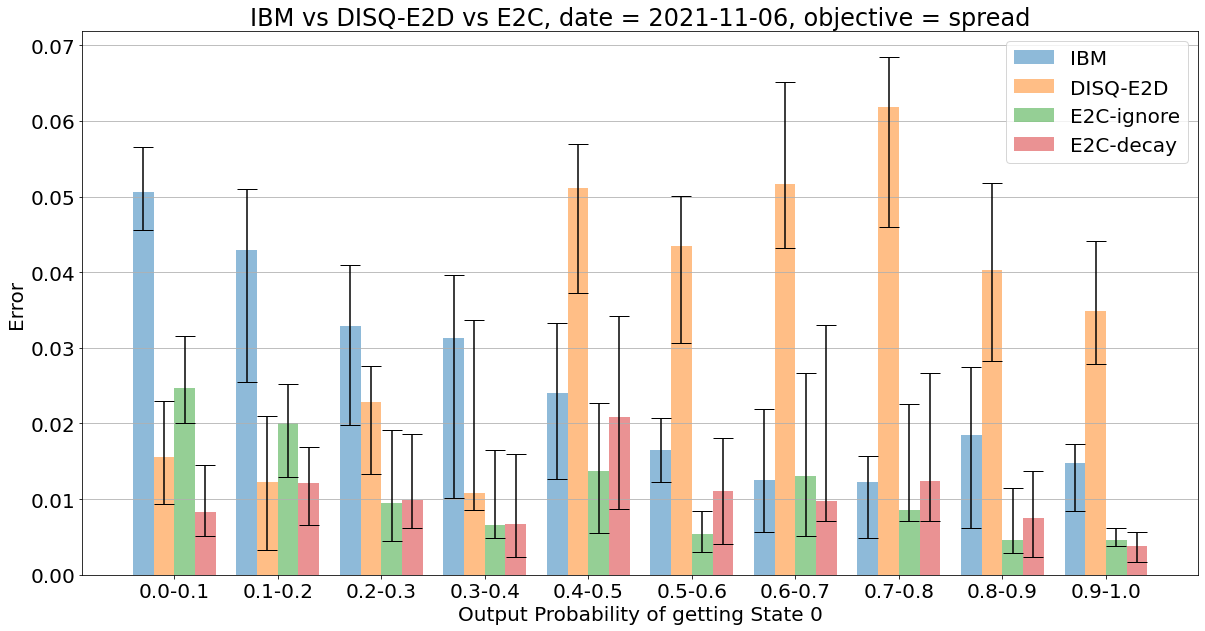

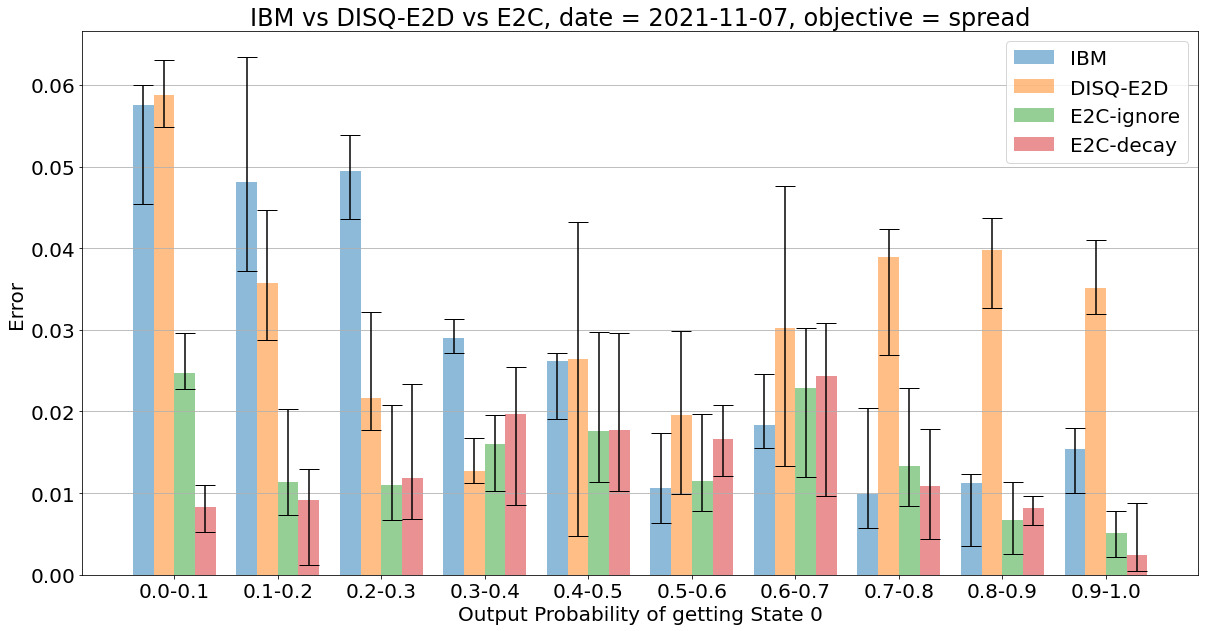

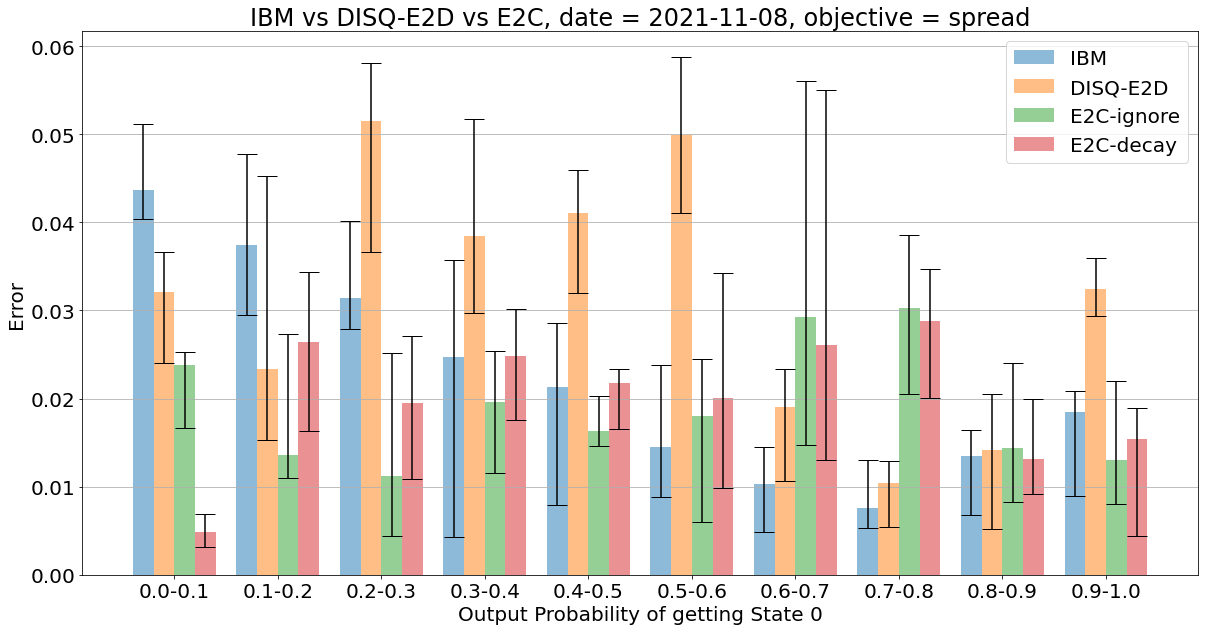

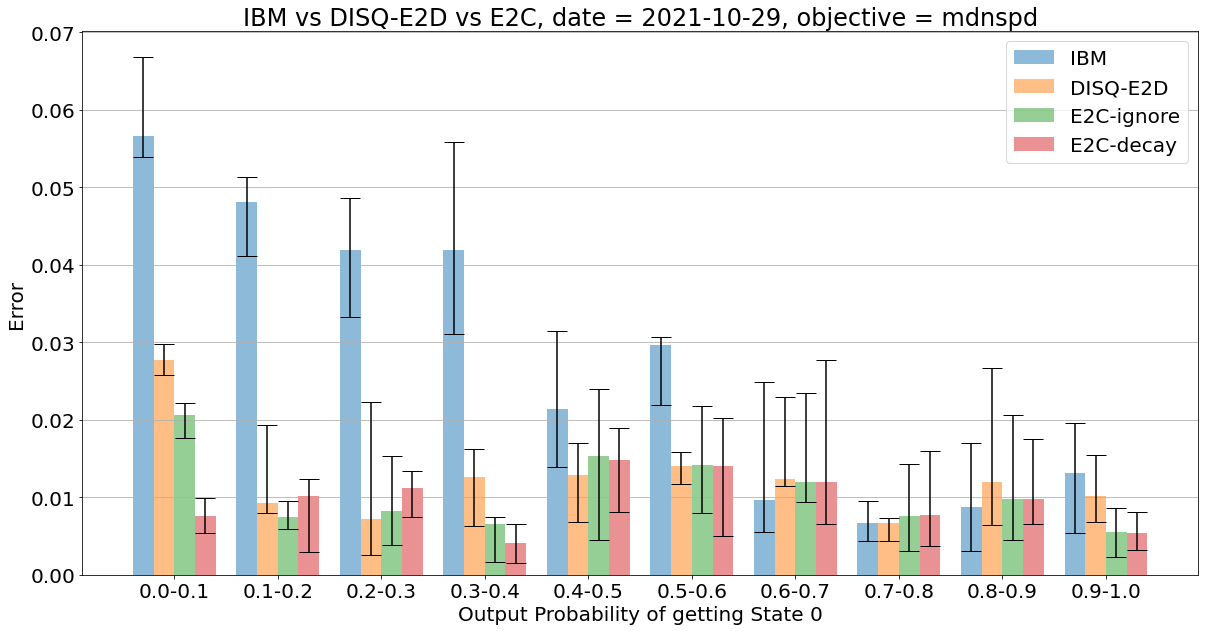

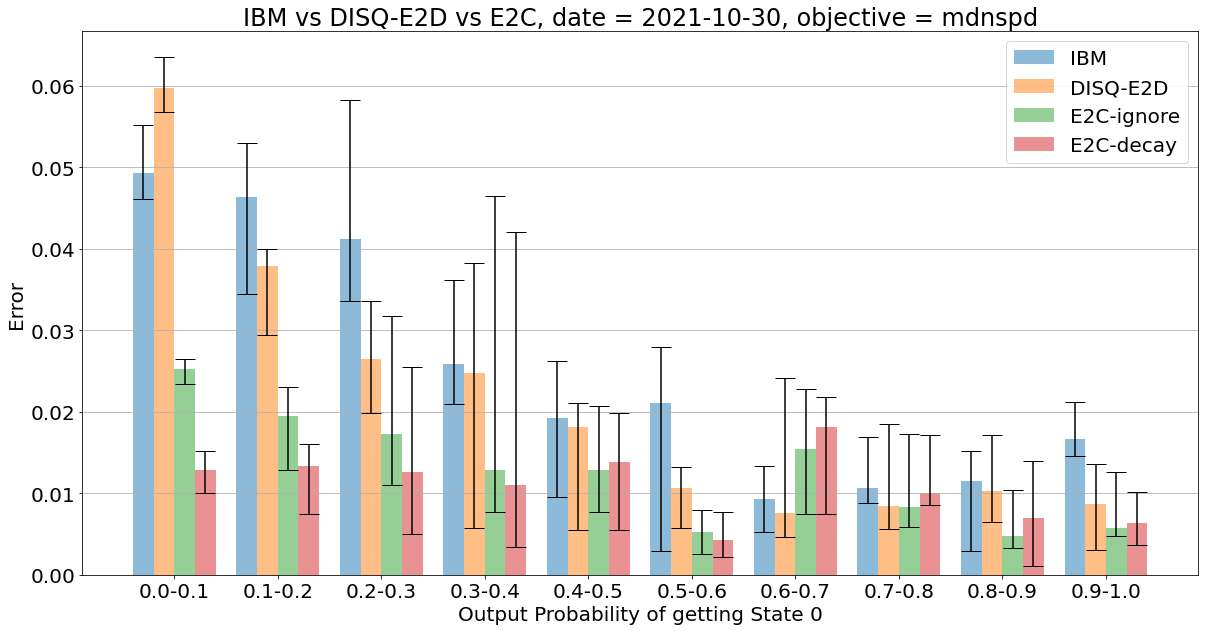

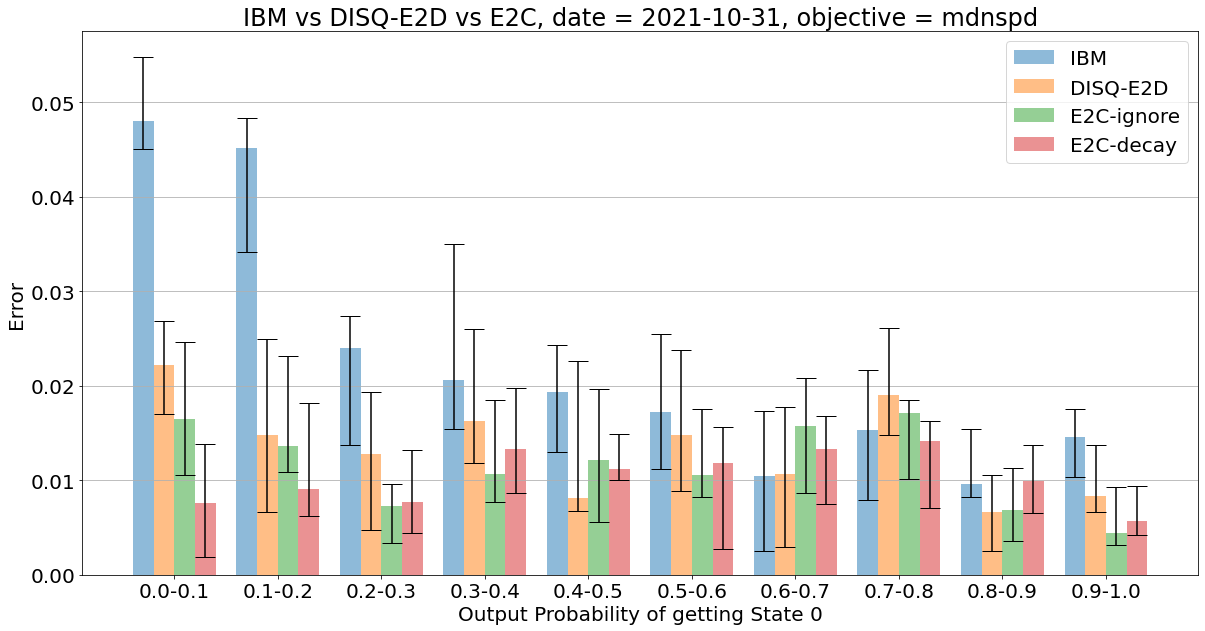

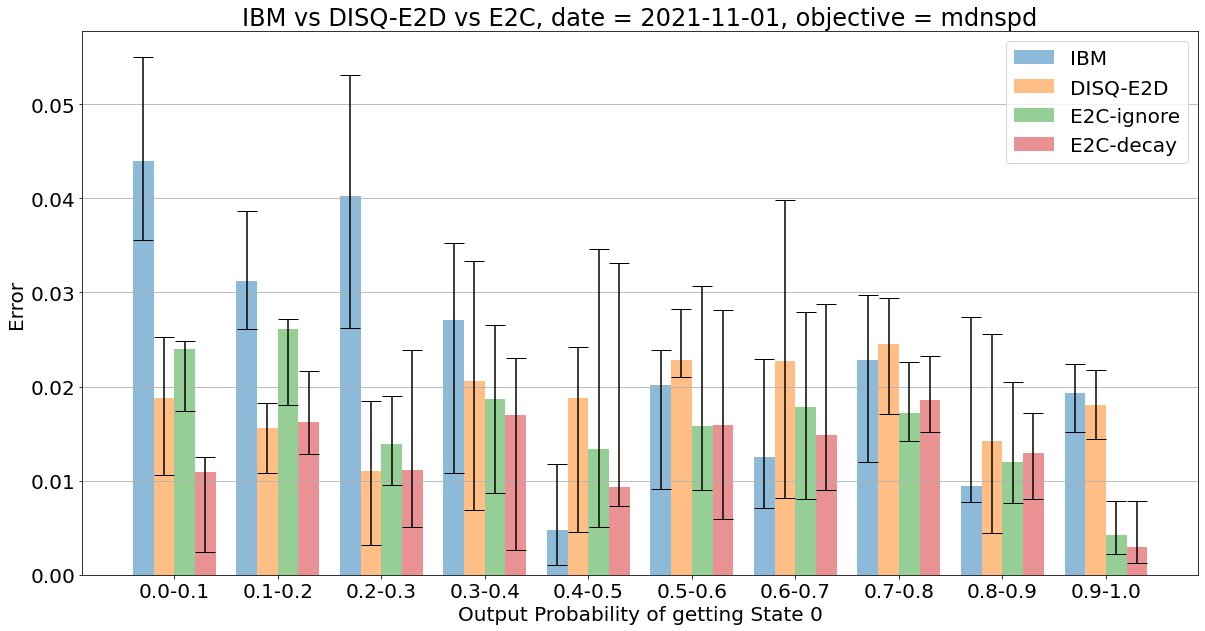

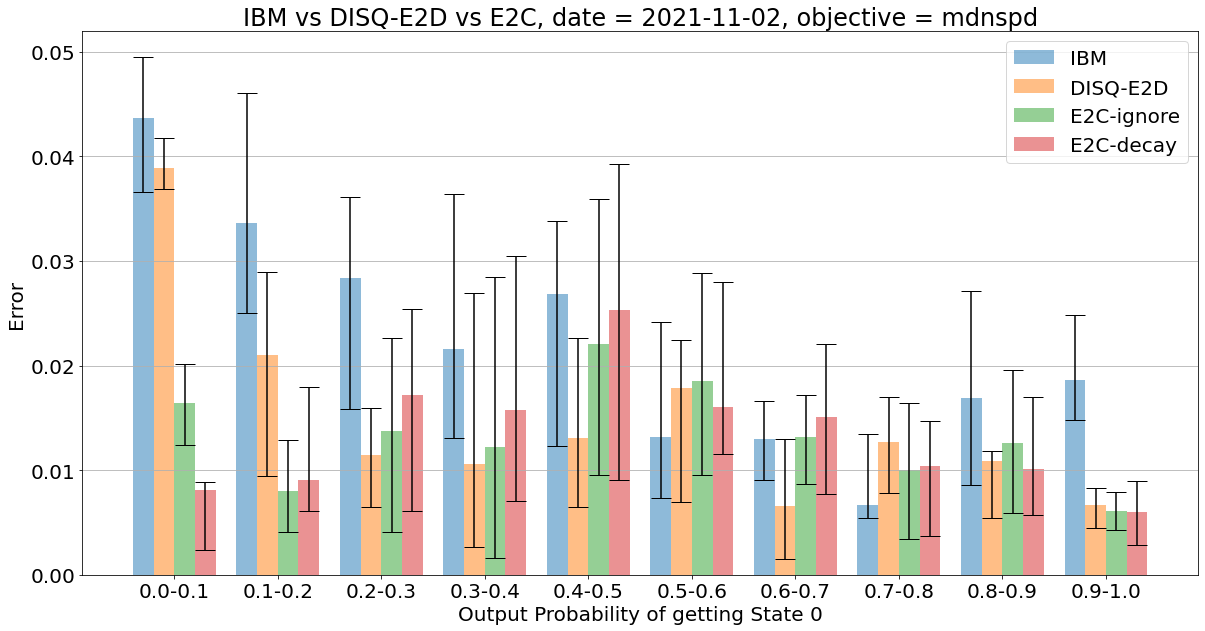

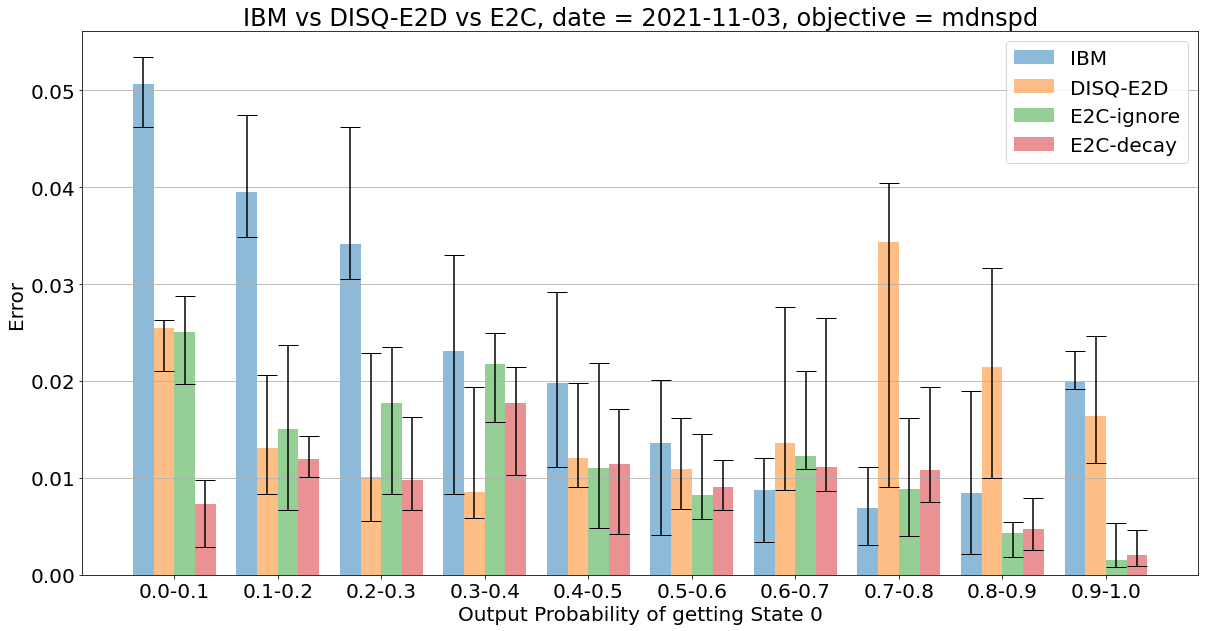

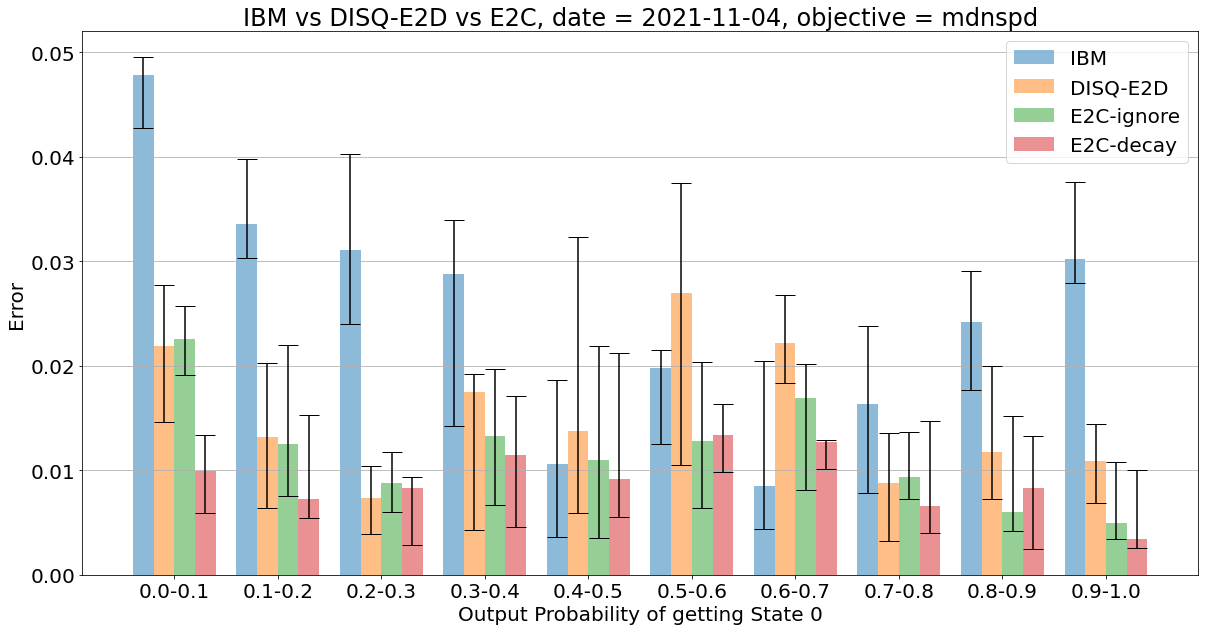

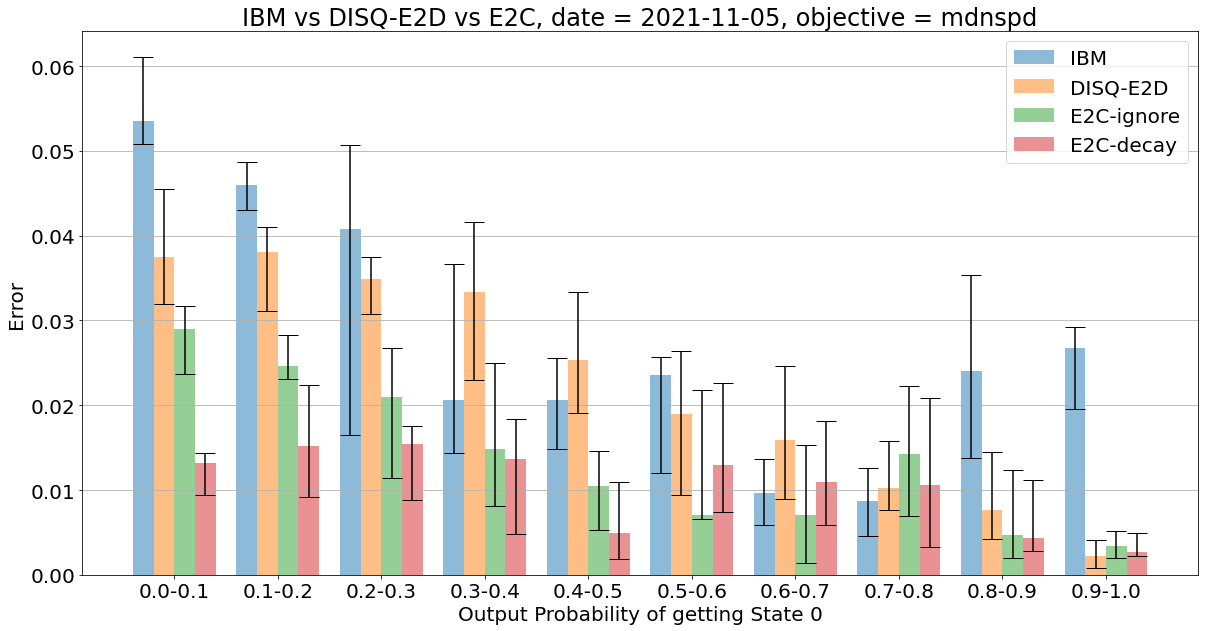

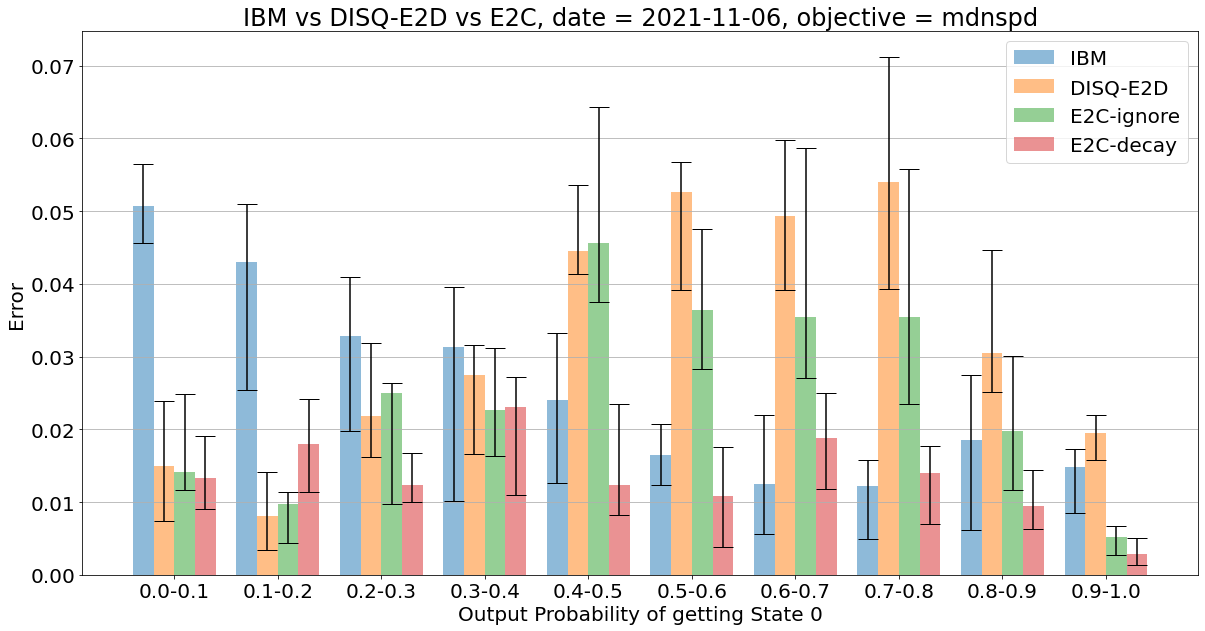

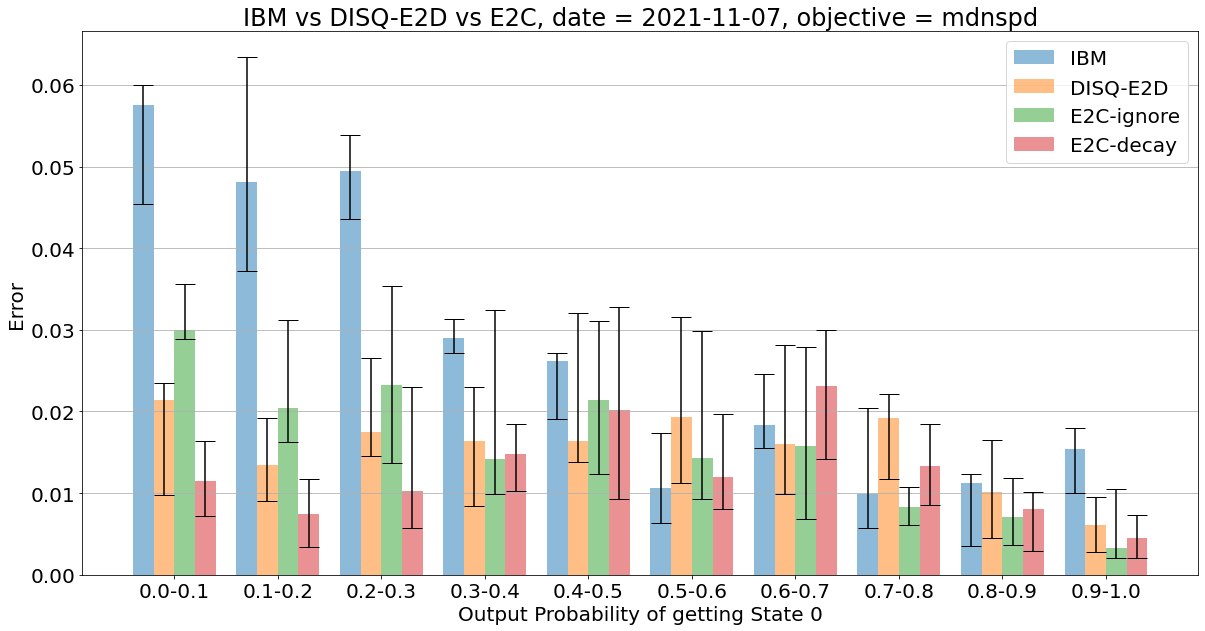

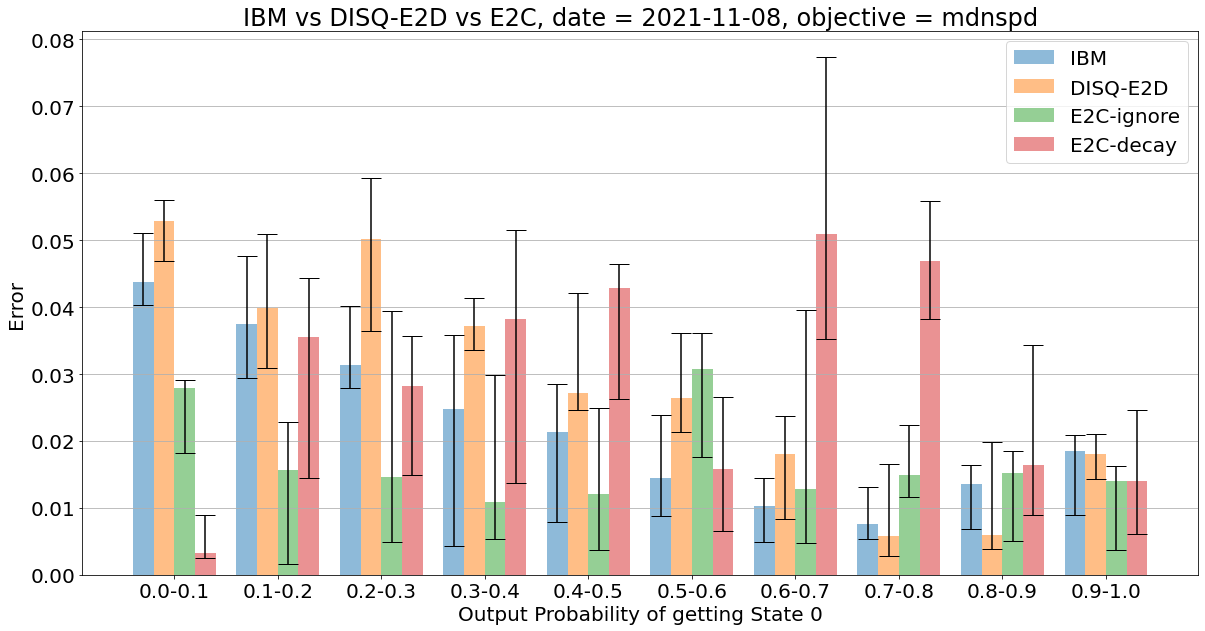

In [4]:
## Initialize variables for the "average across days" plot
aveday_E2Ci = {}
aveday_E2Cd = {}
aveday_DISQ = {}
aveday_IBM = {}

## Some plot details first
err_prob_labels = ["0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8", "0.8-0.9", "0.9-1.0"]
x_pos = np.arange(len(err_prob_labels))
x_width = 0.2
x_pos_skew = [-1.5*x_width, -0.5*x_width, 0.5*x_width, 1.5*x_width]

## Iterate through the objectives
for obj in objectives:
    ## Each of the elements of these 4 arrays are arrays of 3. They are ordered as: 
    ## [25th percentile (distance from median), median, 75th percentile (distance from median)]
    ## The distance from median is used instead of raw percentile so it is easier to plot
    temp_aveday_E2Ci = []
    temp_aveday_E2Cd = []
    temp_aveday_DISQ = []
    temp_aveday_IBM = []
    
    ## Iterate through the dates
    for dd in date_dir:
        ## Declare the plot
        fig, ax = plt.subplots()
        fig.set_size_inches(20,10)
        ax.set_ylabel('Error')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(err_prob_labels)
        ax.set_xlabel('Output Probability of getting State 0')
        ax.yaxis.grid(True)

        # Get evaluation data
        eval_0_p = np.load("../data3/" + dd + '/valid_o_p.npy')
        eval_d_1 = np.load("../data3/" + dd + '/valid_d_1.npy')

        ########################################## IBM  ############################################################
        valid_0_p = np.load("../data3/" + dd + '/valid_o_p.npy')
        valid_d_2 = np.load("../data3/" + dd + '/valid_d_2.npy')

        ## Populate the ibm_err array
        ibm_err = [[] for i in range(len(err_prob_labels))]
        for i in range(len(valid_0_p)):
            index = int(valid_0_p[i] * 10)
            ibm_err[index].append(abs(valid_0_p[i] - valid_d_2[i]/1024))

        ibm_err_prob_median = [0]*len(err_prob_labels)
        ibm_err_prob_25pe = [0]*len(err_prob_labels)
        ibm_err_prob_75pe = [0]*len(err_prob_labels)

        for i in range(len(ibm_err_prob_median)):
            ibm_err_prob_median[i] = np.percentile(ibm_err[i], 50)
            ibm_err_prob_25pe[i] = np.percentile(ibm_err[i], 50) - np.percentile(ibm_err[i], 25)
            ibm_err_prob_75pe[i] = np.percentile(ibm_err[i], 75) - np.percentile(ibm_err[i], 50)

        temp_aveday_IBM.append([ibm_err_prob_25pe, ibm_err_prob_median, ibm_err_prob_75pe])
        ## Plot
        ibm = ax.bar(x_pos + x_pos_skew[0], ibm_err_prob_median, x_width, yerr=[ibm_err_prob_25pe, ibm_err_prob_75pe], alpha=0.5, ecolor='black', capsize=10, label = "IBM")

        ######################################## DISQ (E2D)  ########################################################
        configs = np.load("../data3/" + dd + "/" + "E2D_" + obj + "_" + "configs.npy")
        perform = np.load("../data3/" + dd + "/" + "E2D_" + obj + "_" + "perform.npy")
        
        ## Get the configurations with the best training performance
        best_config_index = np.where(perform == min(perform))

        ## Populate the e2d_err_prob array
        e2d_err = E2D_sample_perf(configs[best_config_index][0], obj, eval_d_1, eval_0_p)
        e2d_err_prob = [[] for i in range(len(err_prob_labels))]
        for i in range(len(e2d_err)):
            index = int(eval_0_p[i] * 10)
            e2d_err_prob[index].append(e2d_err[i])

        e2d_err_prob_median = [0]*len(err_prob_labels)
        e2d_err_prob_25pe = [0]*len(err_prob_labels)
        e2d_err_prob_75pe = [0]*len(err_prob_labels)

        for i in range(len(e2d_err_prob_median)):
            e2d_err_prob_median[i] = np.percentile(e2d_err_prob[i], 50)
            e2d_err_prob_25pe[i] = np.percentile(e2d_err_prob[i], 50) - np.percentile(e2d_err_prob[i], 25)
            e2d_err_prob_75pe[i] = np.percentile(e2d_err_prob[i], 75) - np.percentile(e2d_err_prob[i], 50)

        temp_aveday_DISQ.append([e2d_err_prob_25pe, e2d_err_prob_median, e2d_err_prob_75pe])
        ## Plot
        disq = ax.bar(x_pos + x_pos_skew[1], e2d_err_prob_median, x_width, yerr=[e2d_err_prob_25pe, e2d_err_prob_75pe], alpha=0.5, ecolor='black', capsize=10, label = "DISQ-E2D")

        ######################################## E2C_ignore & E2C_decay  ############################################
        
        ## E2C_ignore and decay
        for mode in ["ignore", "decay"]:
            configs = np.load("../data3/" + dd + "/E2C_" + mode + "_" + obj + "_" + "configs.npy")
            perform = np.load("../data3/" + dd + "/E2C_" + mode + "_" + obj + "_" + "perform.npy")

#             best_config_index = np.where(perform == min(perform))
#             print(min(perform))
#             configs = configs[best_config_index][0]

            ## There is only 1 configuration, so this works
            configs = configs[0]
            decay_prob = configs[0]

            ## Initialize the ellipses
            E_state0 = EllipseC(configs[1], configs[2], configs[3], configs[4])
            E_state1 = EllipseC(configs[5], configs[6], configs[7], configs[8])

            ## Populate the err_prob
            err = getError(eval_d_1, eval_0_p, decay_prob, E_state0, E_state1, mode)
            err_prob = [[] for i in range(len(err_prob_labels))]
            for i in range(len(err)):
                index = int(eval_0_p[i] * 10)
                err_prob[index].append(err[i])

            err_prob_median = [0]*len(err_prob_labels)
            err_prob_25pe = [0]*len(err_prob_labels)
            err_prob_75pe = [0]*len(err_prob_labels)

            for i in range(len(err_prob_median)):
                err_prob_median[i] = np.percentile(err_prob[i], 50)
                err_prob_25pe[i] = np.percentile(err_prob[i], 50) - np.percentile(err_prob[i], 25)
                err_prob_75pe[i] = np.percentile(err_prob[i], 75) - np.percentile(err_prob[i], 50)

            ## Based on the mode, plot
            if mode == "ignore":
                temp_aveday_E2Ci.append([err_prob_25pe, err_prob_median, err_prob_75pe])
                ellipse = ax.bar(x_pos + x_pos_skew[2], err_prob_median, x_width, yerr=[err_prob_25pe, err_prob_75pe], alpha=0.5, ecolor='black', capsize=10, label = "E2C-ignore")
            elif mode == "decay":
                temp_aveday_E2Cd.append([err_prob_25pe, err_prob_median, err_prob_75pe])
                ellipse = ax.bar(x_pos + x_pos_skew[3], err_prob_median, x_width, yerr=[err_prob_25pe, err_prob_75pe], alpha=0.5, ecolor='black', capsize=10, label = "E2C-decay")

        ax.legend()
        ax.set_title(f'IBM vs DISQ-E2D vs E2C, date = {dd}, objective = {obj}')
    
    temp_aveday_IBM = np.array(temp_aveday_IBM)
    temp_aveday_DISQ = np.array(temp_aveday_DISQ)
    temp_aveday_E2Ci = np.array(temp_aveday_E2Ci)
    temp_aveday_E2Cd = np.array(temp_aveday_E2Cd)
    
    ## Get the average across days of the 25th percentile, median, and 75th percentile
    aveday_IBM[obj] = [[np.mean(temp_aveday_IBM[:,j,i]) for i in range(10)] for j in range(3)]
    aveday_DISQ[obj] = [[np.mean(temp_aveday_DISQ[:,j,i]) for i in range(10)] for j in range(3)]
    aveday_E2Ci[obj] = [[np.mean(temp_aveday_E2Ci[:,j,i]) for i in range(10)] for j in range(3)]
    aveday_E2Cd[obj] = [[np.mean(temp_aveday_E2Cd[:,j,i]) for i in range(10)] for j in range(3)]

#### Average Error across all the dates

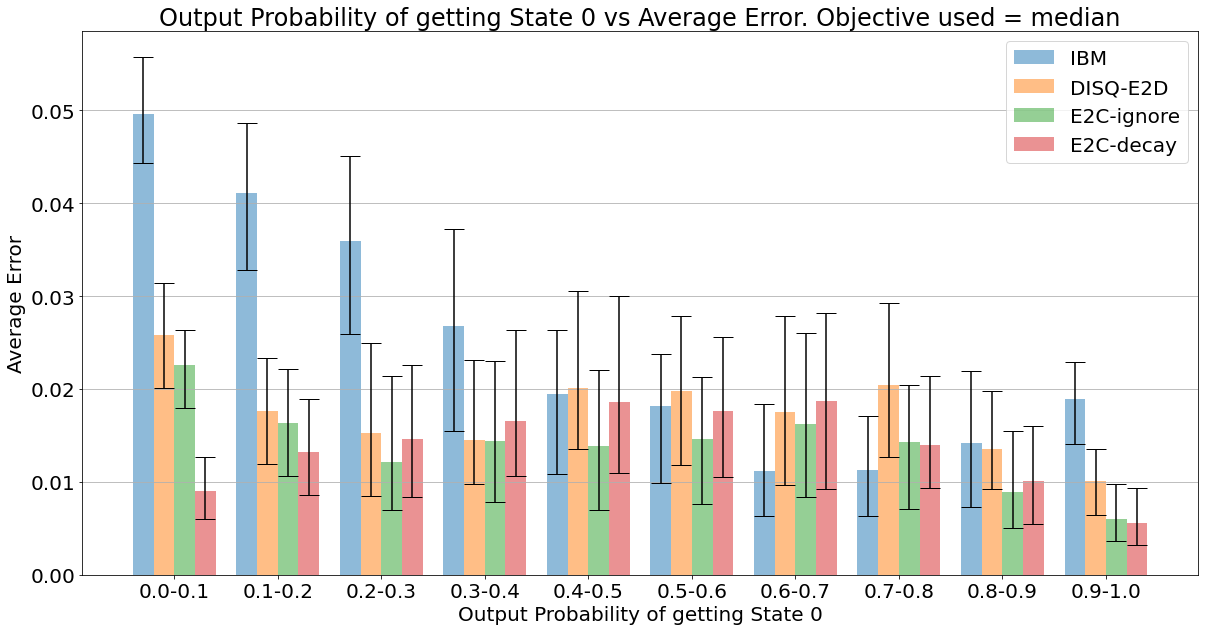

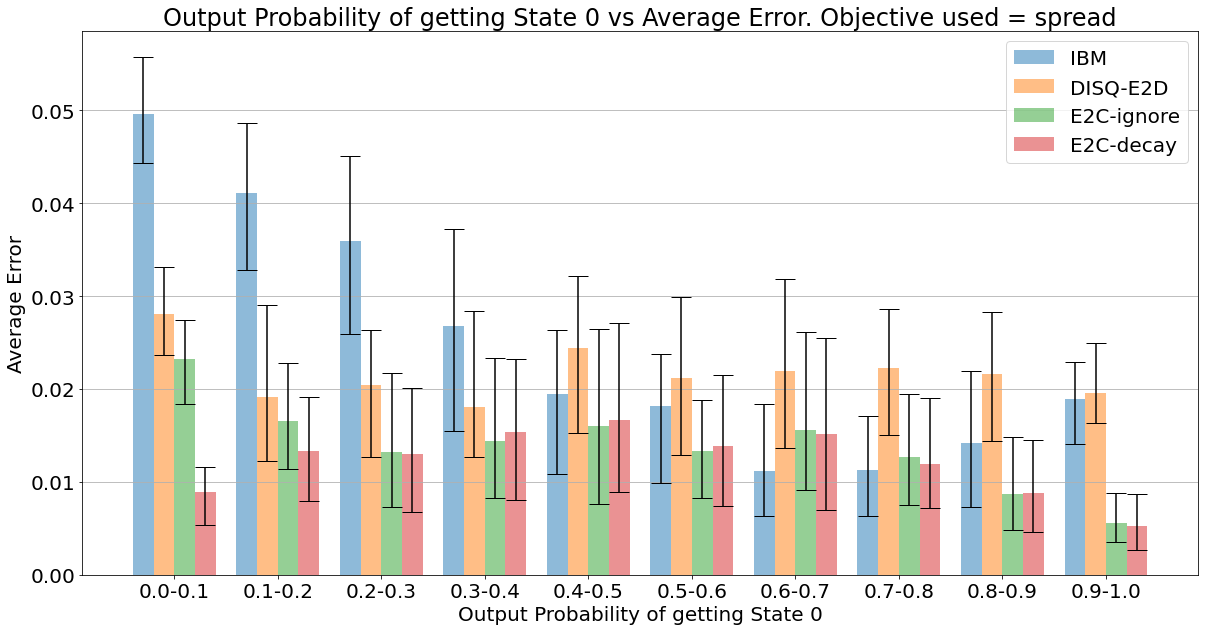

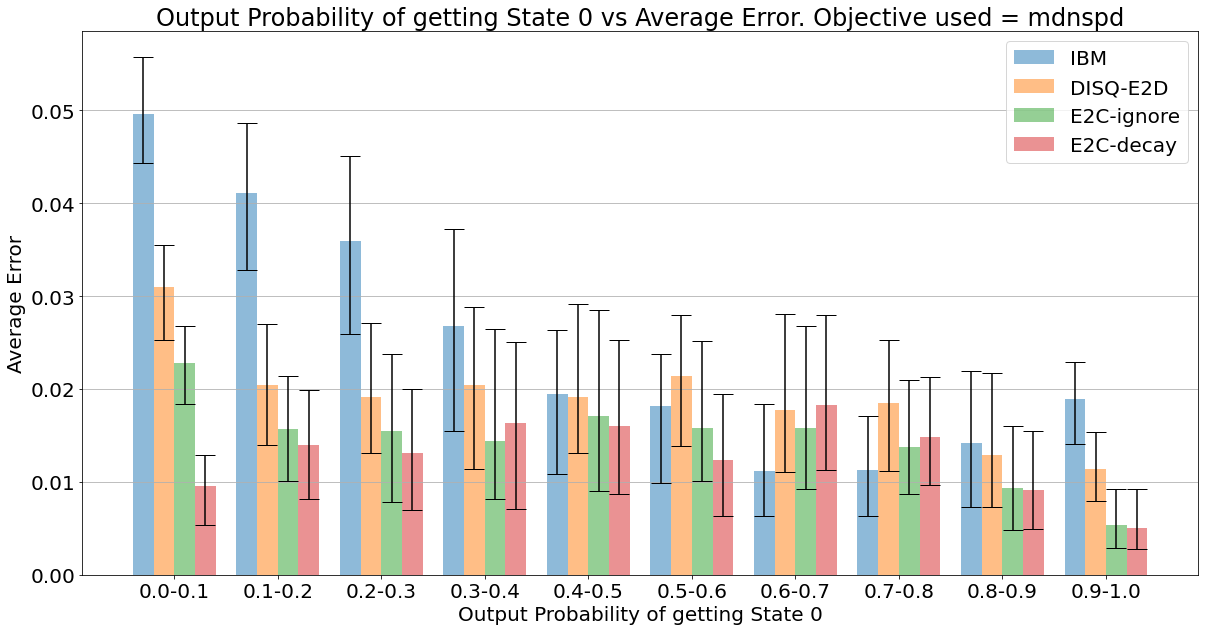

In [5]:
for obj in objectives:
    ## Initialize the plot
    fig, ax = plt.subplots()
    fig.set_size_inches(20,10)

    ax.bar(x_pos + x_pos_skew[0], aveday_IBM[obj][1], x_width, yerr=[aveday_IBM[obj][0], aveday_IBM[obj][2]], alpha=0.5, ecolor='black', capsize=10, label = "IBM")
    ax.bar(x_pos + x_pos_skew[1], aveday_DISQ[obj][1], x_width, yerr=[aveday_DISQ[obj][0], aveday_DISQ[obj][2]], alpha=0.5, ecolor='black', capsize=10, label = "DISQ-E2D")
    ax.bar(x_pos + x_pos_skew[2], aveday_E2Ci[obj][1], x_width, yerr=[aveday_E2Ci[obj][0], aveday_E2Ci[obj][2]], alpha=0.5, ecolor='black', capsize=10, label = "E2C-ignore")
    ax.bar(x_pos + x_pos_skew[3], aveday_E2Cd[obj][1], x_width, yerr=[aveday_E2Cd[obj][0], aveday_E2Cd[obj][2]], alpha=0.5, ecolor='black', capsize=10, label = "E2C-decay")

    ax.set_ylabel('Average Error')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(err_prob_labels)
    ax.legend()
    ax.set_xlabel('Output Probability of getting State 0')
    ax.yaxis.grid(True)
    ax.set_title(f'Output Probability of getting State 0 vs Average Error. Objective used = {obj}')

## Median Error, 75th percentile Error, and Error Spread daily (not shown) and across all days vs the objective function used for SA in E2D_DISQ, E2C_ignore, and E2C_delay

#### Plot details

In [6]:
labels_x = ["Obj = median", "Obj = spread", "Obj = mdnspd"]
labels_legend = ["IBM", "DISQ", "E2C_ignore", "E2C_decay"]
x_pos = np.arange(len(labels_x))
x_width = 0.2
offset = [-1.5*x_width, -0.5*x_width, 0.5*x_width, 1.5*x_width]

### Function Declaration

In [7]:
## Get the error in a specific date using a specific objective function and classifier
def err_perDay(date_dir, obj, classifier):
    err_day = []
    for dd in date_dir:
        eval_0_p = np.load("../data3/" + dd + '/valid_o_p.npy')
        eval_d_1 = np.load("../data3/" + dd + '/valid_d_1.npy')
        
        valid_0_p = np.load("../data3/" + dd + '/valid_o_p.npy')
        valid_d_2 = np.load("../data3/" + dd + '/valid_d_2.npy')
        
        if classifier == "E2C_ignore" or classifier == "E2C_decay":
            configs = np.load("../data3/" + dd + "/" + classifier + "_" + obj + "_" + "configs.npy")
            perform = np.load("../data3/" + dd + "/" + classifier + "_" + obj + "_" + "perform.npy")
            runtime = np.load("../data3/" + dd + "/" + classifier + "_" + obj + "_" + "runtime.npy")
            
            configs = configs[0]
            decay_prob = configs[0]
            
            E_state0 = EllipseC(configs[1], configs[2], configs[3], configs[4])
            E_state1 = EllipseC(configs[5], configs[6], configs[7], configs[8])
           
            err = getError(eval_d_1, eval_0_p, decay_prob, E_state0, E_state1, classifier[4:])
            
            err_day.append(err)
        elif classifier == "IBM":
            ibm_err = [abs(valid_0_p[i] - valid_d_2[i]/1024) for i in range(len(valid_0_p))]

            err_day.append(ibm_err)
        elif classifier == "DISQ":
            configs = np.load("../data3/" + dd + "/E2D_" + obj + "_" + "configs.npy")
            perform = np.load("../data3/" + dd + "/E2D_" + obj + "_" + "perform.npy")
            runtime = np.load("../data3/" + dd + "/E2D_" + obj + "_" + "runtime.npy")
            
            best_config_index = np.where(perform == min(perform))

            e2d_err = E2D_sample_perf(configs[best_config_index][0], obj, eval_d_1, eval_0_p)
            
            err_day.append(e2d_err)
    return err_day


## Err_cls_obj is errors[index indicates classifier][key indicates obj func used in SA]. This applies to all functino below
## Returns data used for daily plotting
def plotDataObj(err_cls_obj, error_type, date_index):
    if error_type == "median":
        return np.median(err_cls_obj[date_index])
    elif error_type == "75p":
        return np.percentile(err_cls_obj[date_index], 75)
    else:
        return np.percentile(err_cls_obj[date_index], 75) - np.percentile(err_cls_obj[date_index], 25)

## Returns data used for average across all days plot
def plotDataObjAverage(err_cls_obj, error_type):
    if error_type == "median":
        median_err_per_day = [np.median(err_day) for err_day in err_cls_obj]
        return np.mean(median_err_per_day)
    elif error_type == "75p":
        p75_err_per_day = [np.percentile(err_day, 75) for err_day in err_cls_obj]
        return np.mean(p75_err_per_day)
    else:
        spread_err_per_day = [np.percentile(err_day, 75) - np.percentile(err_day, 25) for err_day in err_cls_obj]
        return np.mean(spread_err_per_day)

def plotDaily(errors, error_type):
    for di in range(len(date_dir)):
        fig, ax = plt.subplots()
        fig.set_size_inches(20, 8)
    
        plt_data = [[plotDataObj(errors[i][obj], error_type, di) for obj in objectives] for i in range(len(errors))]
        
        for p in range(len(plt_data)):
            ax.bar(x_pos + offset[p], plt_data[p], x_width, alpha=0.5, ecolor='black', label=labels_legend[p])
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels_x)
        ax.legend()
        ax.set_xlabel('Objective function in Simulated Annealing')
        ax.yaxis.grid(True)
        s = "Error Spread"
        if error_type == "median":
            s = "Median Error"
        elif error_type == "75p":
            s = "75th Percentile Error"
        
        ax.set_title(f'IBM vs DISQ-E2D vs E2C, date = {date_dir[di]}: {s}')
        ax.set_ylabel(f'{s}')
        
        plt.show()
        
def plotAverage(errors, error_type):
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    
    plt_data = [[plotDataObjAverage(errors[i][obj], error_type) for obj in objectives] for i in range(len(errors))]

    for p in range(len(plt_data)):
        ax.bar(x_pos + offset[p], plt_data[p], x_width, alpha=0.5, ecolor='black', label=labels_legend[p])

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_x)
    ax.legend()
    ax.set_xlabel('Objective function in Simulated Annealing')
    ax.yaxis.grid(True)
    
    s = "Error Spread"
    if error_type == "median":
        s = "Median Error"
    elif error_type == "75p":
        s = "75th Percentile Error"
    
    ax.set_title(f'Objective function used in SA vs Average {s}')
    ax.set_ylabel(f'{s}')
    
    return fig, ax

#### Main

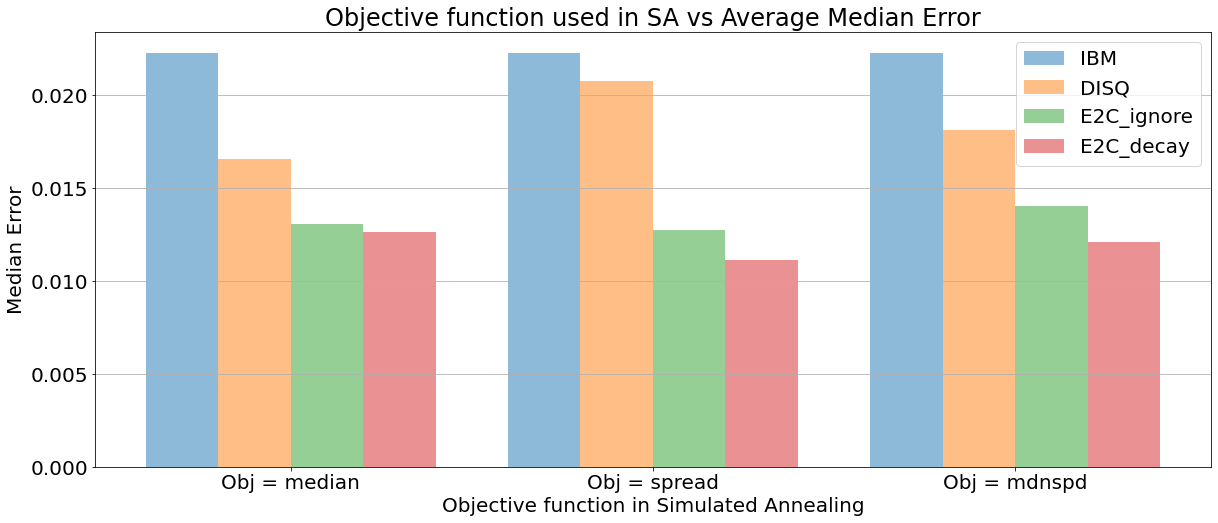

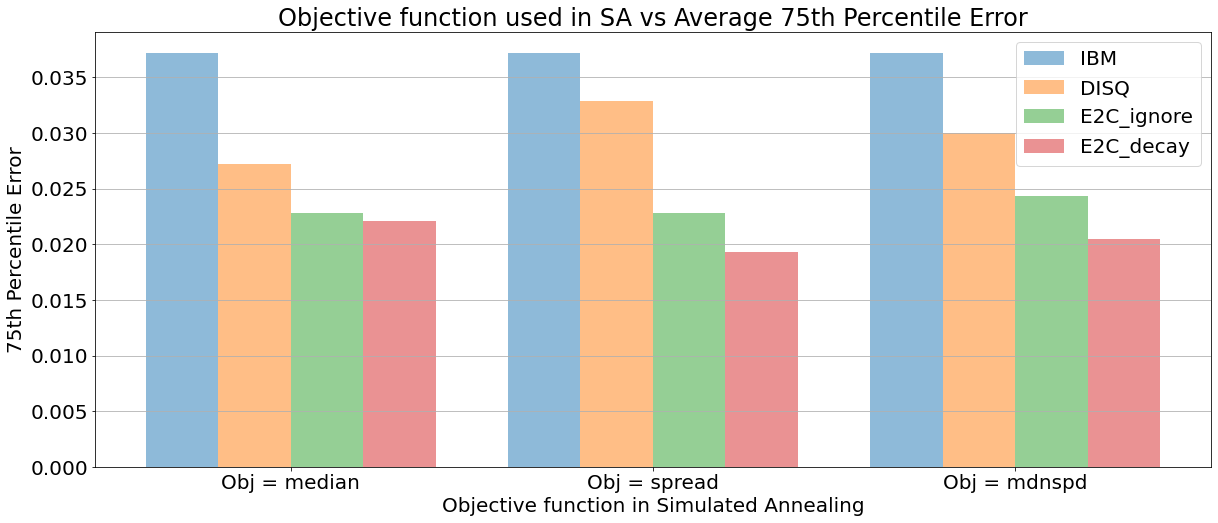

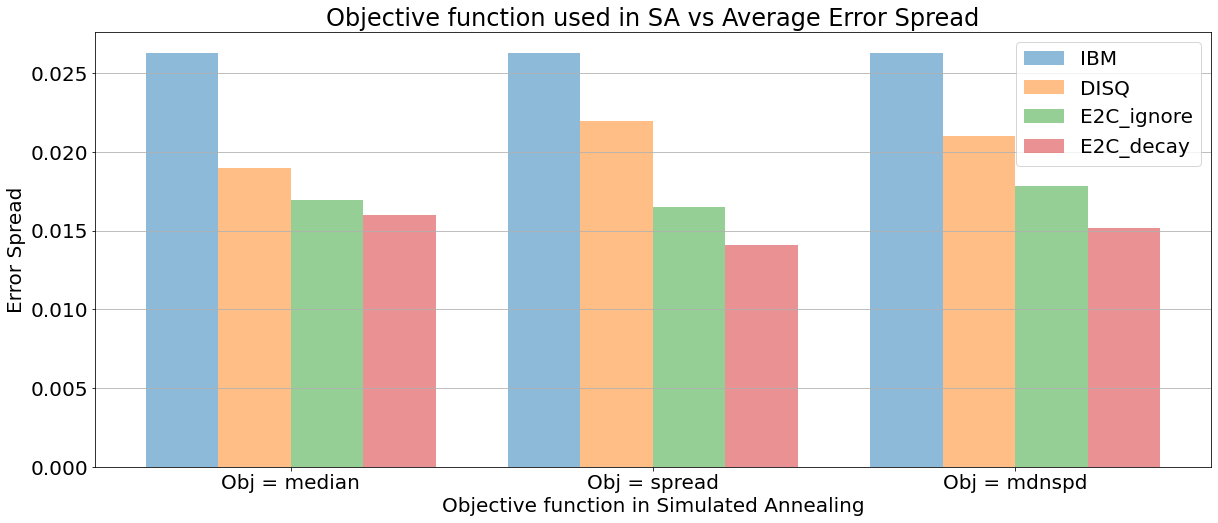

In [8]:
errors = [{}, {}, {}, {}]
for obj in objectives:
    errors[0][obj] = err_perDay(date_dir, obj, "IBM")
    errors[1][obj] = err_perDay(date_dir, obj, "DISQ")
    errors[2][obj] = err_perDay(date_dir, obj, "E2C_ignore")
    errors[3][obj] = err_perDay(date_dir, obj, "E2C_decay")

error_types = ["median", "75p", "spread"]

for err_t in error_types:

#     plotDaily(errors, err_t)
    plotAverage(errors, err_t)
    plt.show()
    
ave_obj_err = errors.copy()

## Check how error changes based on how much training data is used

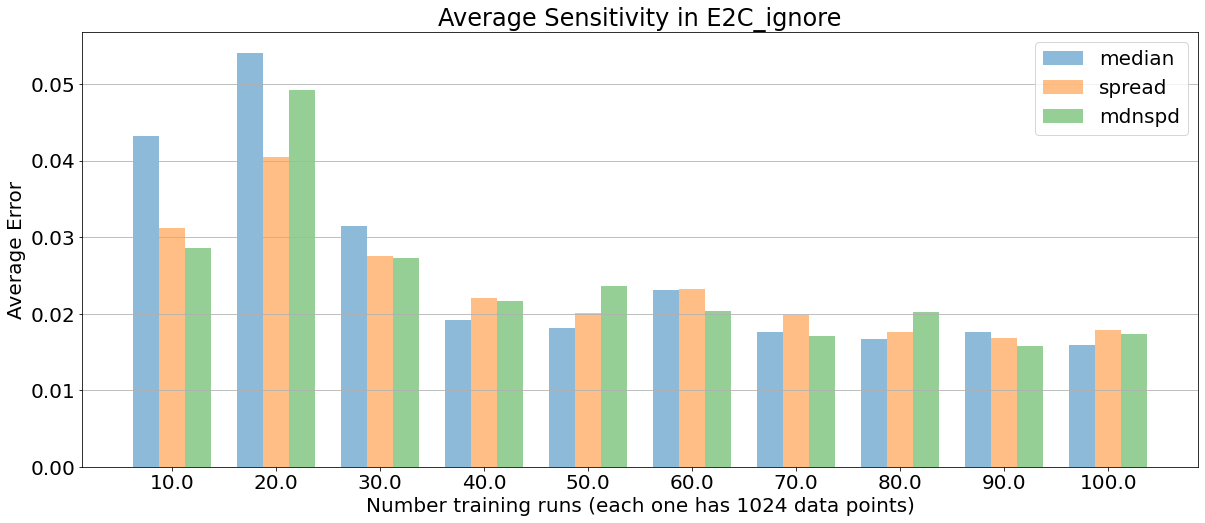

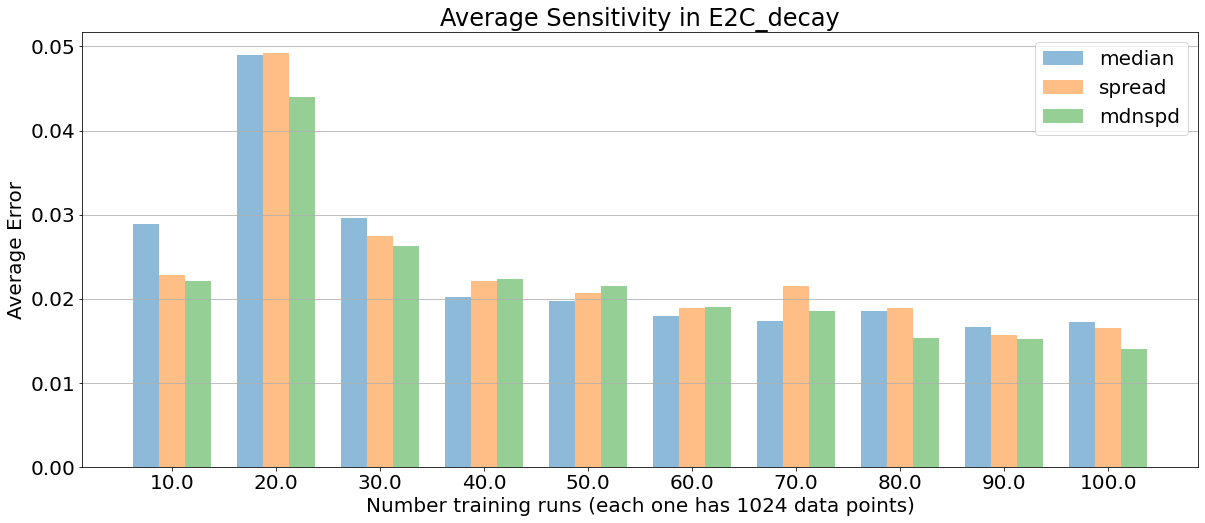

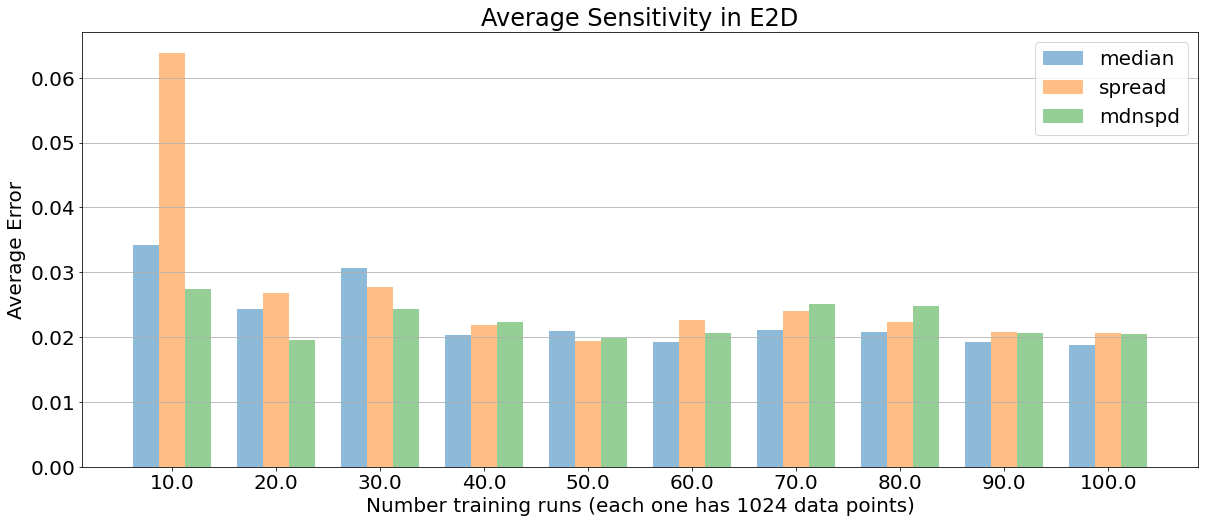

In [13]:
## Define the classifiers to iterate through
classifiers = ["E2C_ignore", "E2C_decay", "E2D"]

## Define Plot information first
labels_x = [100*i/10 for i in range(1,11)]
x_pos = np.arange(len(labels_x))
x_width = 0.25

## Iterate through each classifier
for c in classifiers:
    ## Declare the plot
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    
    for obj in objectives:
        err_daily_ave_partition = []
        
        for dd in date_dir:
            eval_0_p = np.load("../data3/" + dd + '/valid_o_p.npy')
            eval_d_1 = np.load("../data3/" + dd + '/valid_d_1.npy')
            
            err_partition = []
            configs = np.load("../data3/" + dd + "/sensitivity_" + c + "_" + obj + "_" + "configs.npy")
            
            ## Each element in configuration is related to how many training samples were used to train the classifier
            ## Here, partition refers to groups based on the amount of training data used
            for part in configs:
                if c == "E2D":
                    err = E2D_sample_perf(part, obj, eval_d_1, eval_0_p)
                    err_partition.append(np.mean(err))
                else:
                    E_state0 = EllipseC(part[1], part[2], part[3], part[4])
                    E_state1 = EllipseC(part[5], part[6], part[7], part[8])
                    err = getError(eval_d_1, eval_0_p, part[0], E_state0, E_state1, c[4:])
                    err_partition.append(np.mean(err))
            ## Get the average error per partition in a specific day (dd)
            err_daily_ave_partition.append(err_partition)
             
        ## Look at sensitivity per day (make sure you comment out the first fig,ax above and the plotting code below)
#         for e in err_daily_ave_partition:
#             fig, ax = plt.subplots()
#             fig.set_size_inches(20, 8)
#             if obj == "median":
#                 ax.bar(x_pos - x_width, e, x_width, alpha=0.5, ecolor='black', label=obj)
#             elif obj == "spread":
#                 ax.bar(x_pos, e, x_width, alpha=0.5, ecolor='black', label=obj)
#             else:
#                 ax.bar(x_pos + x_width, e, x_width, alpha=0.5, ecolor='black', label=obj)
                
#             ax.set_xticks(x_pos)
#             ax.set_xticklabels(labels_x)
#             ax.set_xlabel('Number training runs (each one has 1024 data points)')
#             ax.yaxis.grid(True)
#             ax.set_ylabel(f'Average Error')
#             ax.set_title(f'Average Sensitivity in {c}')
#             ax.legend()
#             plt.show()
        
        ## Now, we need to get the average error per partition across all days
        err_ave_partition = []
        for col in range(10):
            part = []
            for daily in err_daily_ave_partition:
                part.append(daily[col])
            err_ave_partition.append(np.mean(part))

        ## Plot according to the objective function
        if obj == "median":
            ax.bar(x_pos - x_width, err_ave_partition, x_width, alpha=0.5, ecolor='black', label=obj)
        elif obj == "spread":
            ax.bar(x_pos, err_ave_partition, x_width, alpha=0.5, ecolor='black', label=obj)
        else:
            ax.bar(x_pos + x_width, err_ave_partition, x_width, alpha=0.5, ecolor='black', label=obj)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_x)
    ax.set_xlabel('Number training runs (each one has 1024 data points)')
    ax.yaxis.grid(True)
    ax.set_ylabel(f'Average Error')
    ax.set_title(f'Average Sensitivity in {c}')
    ax.legend()
    plt.show()
            

## Additional function

In [10]:
## Plots the elliptical classifier boundary to better see where it is located in the IQ plane next to the IQ measurements
def visualizeEllipse_train(E_state0, E_state1, eval_data):
    
    # Convert the 2D array to a 1D array
    eval_data = np.concatenate(eval_data, axis=None)
    
    x = np.real(eval_data)
    y = np.imag(eval_data)
    plt.scatter(x, y, 1, c = 'b')
    t = np.linspace(0, 2*np.pi, 100)
    plt.plot( E_state0.c_x +E_state0.r_x*np.cos(t) , E_state0.c_y+E_state0.r_y*np.sin(t) )
    plt.plot( E_state1.c_x +E_state1.r_x*np.cos(t) , E_state1.c_y+E_state1.r_y*np.sin(t) )
    plt.show()

## Check performance of outdated classifiers compared to updated ones in new data

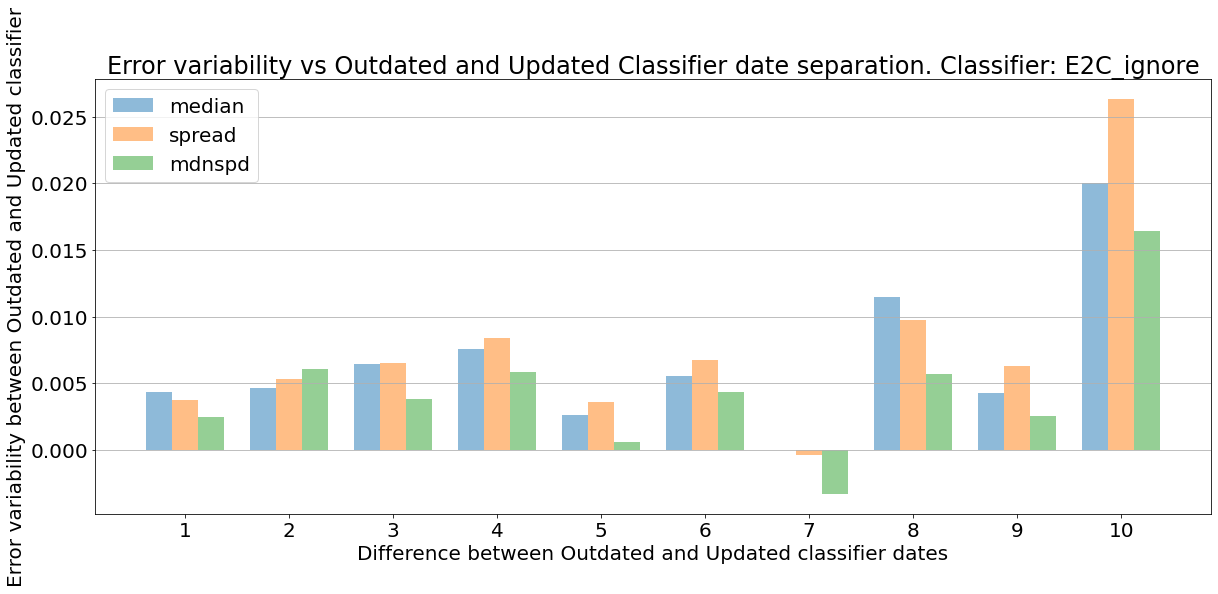

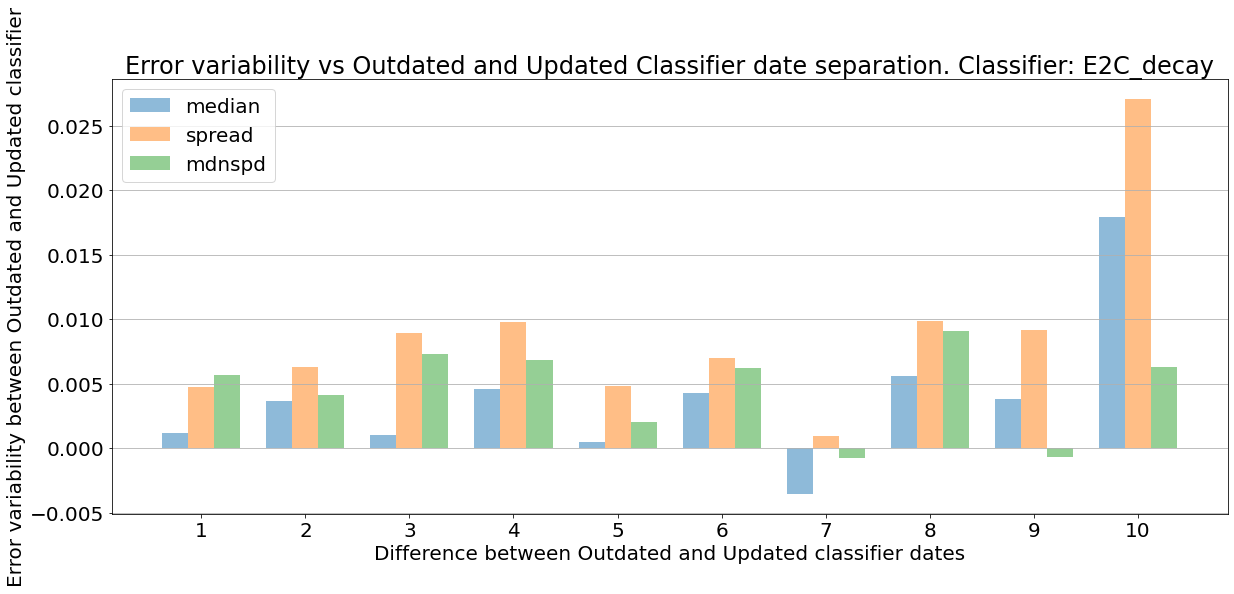

In [11]:
## Get the indices of dates related to classifiers that are going to be used to evaluated data
indices = [[[i, i + j] for i in range(len(date_dir) - j)] for j in range(1, len(date_dir))]
classifiers = ["E2C_ignore", "E2C_decay"]

## Plot information
labels_x = [i for i in range(1, len(indices) + 1)]
x_pos = np.arange(len(labels_x))
x_width = 0.25

## Go through E2C_ignore and then E2C_decay
for c in classifiers:
    
    median_var = []
    spread_var = []
    mdnspd_var = []
    
    sep = 1
    
    for separation in indices:
#         print(f"The separation is of {sep} days")
        sep += 1
        variability = []
        
        ## Go through each index pair in separation.
        for train_i, eval_i in separation:
            dt = date_dir[train_i]
            de = date_dir[eval_i]

            eval_0_p = np.load("../data3/" + de + '/valid_o_p.npy')
            eval_d_1 = np.load("../data3/" + de + '/valid_d_1.npy')
            
#             print(f"Training date: {dt}")
#             print(f"Evaluation date: {de}")

            diff_err = []
            for obj in objectives:
                ## Get the error using old configurations
                configs = np.load("../data3/" + dt + "/" + c + "_" + obj + "_" + "configs.npy")
                configs = configs[0]
                
                E_state0 = EllipseC(configs[1], configs[2], configs[3], configs[4])
                E_state1 = EllipseC(configs[5], configs[6], configs[7], configs[8])
                
                err_old_config = getError(eval_d_1, eval_0_p, configs[0], E_state0, E_state1, c[4:])
#                 print(f"Average error using {dt} as training date: {np.mean(err_old_config)}")
#                 print("Visualize using old")
#                 visualizeEllipse_train(E_state0, E_state1, eval_d_1)
    
                ## Get the error using the same day configuration
                configs = np.load("../data3/" + de + "/" + c + "_" + obj + "_" + "configs.npy")
                configs = configs[0]
                
                E_state0 = EllipseC(configs[1], configs[2], configs[3], configs[4])
                E_state1 = EllipseC(configs[5], configs[6], configs[7], configs[8])

                err_new_config = getError(eval_d_1, eval_0_p, configs[0], E_state0, E_state1, c[4:])
#                 print(f"Average error using {de} as training date: {np.mean(err_new_config)}")
#                 print("Visualize using new")
#                 visualizeEllipse_train(E_state0, E_state1, eval_d_1)
                
                ## The difference is always the error using old config - error using same day config
                diff = np.mean(err_old_config) - np.mean(err_new_config)
                diff_err.append(diff)
            
            variability.append(diff_err)
        
        ## Each element in variability depicts the distance (sep) between the updated and outdated classifier.
        ## In each elements, which are arrays, there are 3 elements which depict median, spread, and mdnspd objective functions
        ## used in a classifier
        v = np.array(variability)
        median_var.append(np.mean(v[:,0]))
        spread_var.append(np.mean(v[:,1]))
        mdnspd_var.append(np.mean(v[:,2]))
    
    ## Setup plot information
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels_x)
    ax.set_xlabel('Difference between Outdated and Updated classifier dates')
    ax.yaxis.grid(True)
    ax.set_ylabel('Error variability between Outdated and Updated classifier')
    ax.set_title(f'Error variability vs Outdated and Updated Classifier date separation. Classifier: {c}')
    
    ax.bar(x_pos - x_width, median_var, x_width, alpha=0.5, ecolor='black', label="median")
    ax.bar(x_pos, spread_var, x_width, alpha=0.5, ecolor='black', label="spread")
    ax.bar(x_pos + x_width, mdnspd_var, x_width, alpha=0.5, ecolor='black', label="mdnspd")
        
    ax.legend()
    plt.show()
    

## Ensembling (This should have been done not with evaluation data)

In [12]:
# def E2D_pred(config, eval_d_1):
#     pred = [1]*len(eval_d_1)
    
#     A0 = (np.cos(config[2])/config[3])**2 + (np.sin(config[2])/config[4])**2
#     B0 = 2 * np.cos(config[2]) * np.sin(config[2]) * ((1/config[3]**2) - (1/config[4]**2))
#     C0 = (np.sin(config[2])/config[3])**2 + (np.cos(config[2])/config[4])**2
    
#     A1 = (np.cos(config[7])/config[8])**2 + (np.sin(config[7])/config[9])**2
#     B1 = 2 * np.cos(config[7]) * np.sin(config[7]) * ((1/config[8]**2) - (1/config[9]**2))
#     C1 = (np.sin(config[7])/config[8])**2 + (np.cos(config[7])/config[9])**2
        
#     for i in range(len(eval_d_1)):
#         x0 = np.real(eval_d_1[i]) - config[0]
#         y0 = np.imag(eval_d_1[i]) - config[1]
#         frac_0 = sum(A0*x0**2 + B0*x0*y0 + C0*y0**2 <= 1)
#         x1 = np.real(eval_d_1[i]) - config[5]
#         y1 = np.imag(eval_d_1[i]) - config[6]
#         frac_1 = sum(A1*x1**2 + B1*x1*y1 + C1*y1**2 <= 1)
#         if frac_0 + frac_1 != 0:
#             frac_0 /= (frac_0 + frac_1)
#             pred[i] = abs(1-frac_0)
            
#     return pred

# def E2C_pred(eval_d_1, decay_prob, E_state0, E_state1, mode):
#     pred = []
#     for i in range(len(eval_d_1)):
#         x = np.real(eval_d_1[i])
#         y = np.imag(eval_d_1[i])

#         num_state_0 = numInEllipse(E_state0, x, y)
#         num_state_1 = numInEllipse(E_state1, x, y)
        
#         num_inter = numBetweenEllipses(E_state0, E_state1, x, y)
        
#         num_state_0 -= num_inter
#         num_state_1 -= num_inter
        
#         if mode == "ignore":
#             prob_0 = num_state_0 / (num_state_0 + num_state_1)
#             pred.append(prob_0)
            
#         elif mode == "decay":
#             num_state_0 -= int(num_state_1*decay_prob)
#             num_state_1 += int(num_state_1*decay_prob)
            
#             prob_0 = num_state_0 / (num_state_0 + num_state_1)
#             pred.append(prob_0)
            
#     return pred

# def getErrorVote(eval_d_1, eval_0_p, eval_d_2, E2D_config, E2Ci_config, E2Cd_config, weights):        
#     E_state0_e2ci = EllipseC(E2Ci_config[1], E2Ci_config[2], E2Ci_config[3], E2Ci_config[4])
#     E_state1_e2ci = EllipseC(E2Ci_config[5], E2Ci_config[6], E2Ci_config[7], E2Ci_config[8])

#     E_state0_e2cd = EllipseC(E2Cd_config[1], E2Cd_config[2], E2Cd_config[3], E2Cd_config[4])
#     E_state1_e2cd = EllipseC(E2Cd_config[5], E2Cd_config[6], E2Cd_config[7], E2Cd_config[8])
#     E2Cd_delay = E2Cd_config[0]

#     ## IBM prediction
#     ibm_pred = eval_d_2/1024

#     ## E2D prediction
#     e2d_pred = E2D_pred(E2D_config, eval_d_1)

#     ## E2C_ignore prediction
#     e2ci_pred = E2C_pred(eval_d_1, 0, E_state0_e2ci, E_state1_e2ci, "ignore")

#     ## E2C_decay prediction
#     e2cd_pred = E2C_pred(eval_d_1, E2Cd_delay, E_state0_e2cd, E_state1_e2cd, "decay")
    
#     err = []
    
#     for i in range(len(eval_0_p)):
#         pred = ibm_pred[i] * weights[0] + e2d_pred[i] * weights[1] + e2ci_pred[i] * weights[2] + e2cd_pred[i] * weights[3]
#         err.append(abs(eval_0_p[i] - pred))
        
#     return err

# weighted = [[i, 0, 0, 1-i] for i in np.linspace(0.05,0.3,20)]

# min_obj_spread_m_err = []
# min_obj_spread_s_err = []
# min_obj_spread_p_err = []

# for w in weighted:
#     print(w)
#     median_err = []
#     spread_err = []
#     percen_err = []
#     for obj in objectives:
#         err_m = []
#         err_s = []
#         err_p = []

#         for dd in date_dir:
#             eval_0_p = np.load("../data3/" + dd + '/valid_o_p.npy')
#             eval_d_1 = np.load("../data3/" + dd + '/valid_d_1.npy')
#             eval_d_2 = np.load("../data3/" + dd + '/valid_d_2.npy')

#             ## For E2D
#             e2d_configs = np.load("../data3/" + dd + "/E2D_" + obj + "_" + "configs.npy")
#             e2d_perform = np.load("../data3/" + dd + "/E2D_" + obj + "_" + "perform.npy")

#             e2d_bci = np.where(perform == min(perform))
#             e2d_configs = e2d_configs[e2d_bci][0]

#             ## For E2C_ignore
#             e2ci_configs = np.load("../data3/" + dd + "/" + "E2C_ignore_" + obj + "_" + "configs.npy")
#             e2ci_perform = np.load("../data3/" + dd + "/" + "E2C_ignore_" + obj + "_" + "perform.npy")

#             e2ci_configs = e2ci_configs[0]

#             ## For E2C_ignore
#             e2cd_configs = np.load("../data3/" + dd + "/" + "E2C_decay_" + obj + "_" + "configs.npy")
#             e2cd_perform = np.load("../data3/" + dd + "/" + "E2C_decay_" + obj + "_" + "perform.npy")

#             e2cd_configs = e2cd_configs[0]

#             err = getErrorVote(eval_d_1, eval_0_p, eval_d_2, e2d_configs, e2ci_configs, e2cd_configs, w)

#             err_m.append(np.median(err))
#             err_s.append(np.percentile(err, 75) - np.percentile(err, 25))
#             err_p.append(np.percentile(err, 75))

#         median_err.append(np.mean(err_m))
#         spread_err.append(np.mean(err_s))
#         percen_err.append(np.mean(err_p))

#     err_to_plt = [median_err, percen_err, spread_err]
    
#     min_obj_spread_m_err.append(median_err[1])
#     min_obj_spread_s_err.append(spread_err[1])
#     min_obj_spread_p_err.append(percen_err[1])

#     labels_x = ["Obj = median", "Obj = spread", "Obj = mdnspd"]
#     labels_legend = ["IBM", "DISQ", "E2C_ignore", "E2C_decay", "Ensemble"]
#     x_pos = np.arange(len(labels_x))
#     x_width = 0.1
#     offset = [-2*x_width, -1*x_width, 0, 1*x_width, 2*x_width]

#     index = 0
#     for err_t in error_types:
#         fig, ax = plotAverage(ave_obj_err, err_t)
#         ax.bar(x_pos + offset[4], err_to_plt[index], x_width, alpha=0.5, ecolor='black', label=labels_legend[4])
#         ax.legend()
#         plt.show()
#         index += 1

# print("Minimum error gotten for median")
# print(min(min_obj_spread_m_err))
# print(f"Weight connected to is: {weighted[min_obj_spread_m_err.index(min(min_obj_spread_m_err))]}")
# print("Minimum error gotten for spread")
# print(min(min_obj_spread_s_err))
# print(f"Weight connected to is: {weighted[min_obj_spread_s_err.index(min(min_obj_spread_s_err))]}")
# print("Minimum error gotten for percentile")
# print(min(min_obj_spread_p_err))
# print(f"Weight connected to is: {weighted[min_obj_spread_p_err.index(min(min_obj_spread_p_err))]}")
